# Generating figures for paper

In [37]:
import pandas as pd
import numpy as np
import scipy
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scienceplots

fsize = 8
tsize = 8
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('grid')
# plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# errbar_kwargs = dict(marker='.', markersize=3, capsize=3, elinewidth=1, lw=1)
# plot_kwargs = dict(marker='.', markersize=3, lw=1)
# errband_kwargs = dict(alpha=0.25)
errbar_kwargs = dict(estimator='mean', errorbar=('ci', 95), errwidth=1.25, capsize=0.05,)

save_dir = '../iclr/figs/experiments'

In [38]:
cmap = plt.cm.tab20

In [39]:
our_model_name = '$DAT$' # 'Dual-Attn Transformer'# 'Orthrus' # 'AbstractTransformer' # Orthrus
transformer_name = '$T$'

## Relational Games

In [347]:
# relgames_data = pd.read_csv('figure_data/relgames/relgames_data.csv')
relgames_data1 = pd.read_csv('figure_data/relgames/relgames_data.csv')
relgames_data2 = pd.read_csv('figure_data_tmp/relgames/relgames_data.csv')
relgames_data = pd.concat([relgames_data1, relgames_data2], ignore_index=True)

def process_groupname(group_name):
    task, model_name = group_name.split('__')
    return model_name


# L, total_n_heads = 2, 2
# filter_ = (relgames_data['n_layers'] == L) & ((relgames_data['n_heads_rca'] + relgames_data['n_heads_sa'] == total_n_heads) | (relgames_data['n_heads'] == total_n_heads)) & (relgames_data['train_size'] <= 25_000)
filter_ = (relgames_data['task'] != '1task_match_patt') | (relgames_data['train_size'] <= 25_000) & (relgames_data['train_size'] > 2500)
figure_data = relgames_data[filter_]

figure_data['Model'] = figure_data['group'].apply(process_groupname)

figure_data.rename(columns={'train_size': 'Training Set Size', 'test/acc_in_distribution': 'Generalization Accuracy', 'task': 'Task'}, inplace=True)

C:\Users\awnya\AppData\Local\Temp\ipykernel_27312\1068816481.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  figure_data['Model'] = figure_data['group'].apply(process_groupname)
C:\Users\awnya\AppData\Local\Temp\ipykernel_27312\1068816481.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  figure_data.rename(columns={'train_size': 'Training Set Size', 'test/acc_in_distribution': 'Generalization Accuracy', 'task': 'Task'}, inplace=True)


In [348]:
def parse_rel_symmetry(group_name):
    if 'sym_rel=True' in group_name:
        return True
    elif 'sym_rel=False' in group_name:
        return False
    else:
        return None

figure_data.loc[:, 'Symmetric RA'] = figure_data['group'].apply(parse_rel_symmetry)

C:\Users\awnya\AppData\Local\Temp\ipykernel_27312\2582143399.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  figure_data.loc[:, 'Symmetric RA'] = figure_data['group'].apply(parse_rel_symmetry)


In [349]:
def parse_attn_symmetry(group_name):
    if 'sym_attn' in group_name:
        return True
    else:
        return False

figure_data.loc[:, 'Symmetric SA'] = figure_data['group'].apply(parse_attn_symmetry)

C:\Users\awnya\AppData\Local\Temp\ipykernel_27312\4101514183.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  figure_data.loc[:, 'Symmetric SA'] = figure_data['group'].apply(parse_attn_symmetry)


In [350]:
figure_data['Symmetric RA'].value_counts(dropna=False)

True     5398
None     3924
False    1431
Name: Symmetric RA, dtype: int64

In [351]:
def parse_symmetry(row):
    sym_sa = bool(row['Symmetric SA'])
    sym_ra = bool(row['Symmetric RA'])
    if sym_sa and sym_ra:
        return 'Symmetric SA, RA'
    elif sym_sa:
        return 'Symmetric SA'
    elif sym_ra:
        return 'Symmetric RA'
    else:
        return 'N/A'

figure_data.loc[:, 'Symmetry'] = pd.Categorical(figure_data.apply(parse_symmetry, axis=1), categories=['N/A', 'Symmetric SA', 'Symmetric RA', 'Symmetric SA, RA'])

C:\Users\awnya\AppData\Local\Temp\ipykernel_27312\715182160.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  figure_data.loc[:, 'Symmetry'] = pd.Categorical(figure_data.apply(parse_symmetry, axis=1), categories=['N/A', 'Symmetric SA', 'Symmetric RA', 'Symmetric SA, RA'])


In [352]:
def get_name(row):

    if row.baseline_model in ['abstractor', 'predinet', 'corelnet']:
        name_map = {'abstractor': 'Abstractor', 'predinet': 'PrediNet', 'corelnet': 'CoRelNet'} # FIXME (swap to CoRelNetSoftmax)
        name = name_map[row.baseline_model]
    elif not np.isnan(row.n_heads):
        name = f'{transformer_name} '
        if row['Symmetric SA']:
            name += '[Symmetric SA] '
        name += f'($n_h^{{sa}}={int(row.n_heads)}, n_h^{{ra}}=0$)'
    else:
        if row.rca_type == 'standard':
            name = "Abstractor's RCA"
        elif row.rca_type == 'disentangled_v2':
            name = our_model_name
        elif row.ra_type == 'relational_attention':
            name = our_model_name + ' [Symmetric SA,RA]'
        else:
            raise ValueError(f'Unknown model: {row.ra_type}')

        if not row['Symmetric RA']:
            name += ' [Asymmetric]'

        sa = row.n_heads_sa
        ra = row.n_heads_rca if not np.isnan(row.n_heads_rca) else row.n_heads_ra

        name += f' ($n_h^{{sa}}={int(sa)}, n_h^{{ra}}={int(ra)}$)'

    name += f' [{int(row.num_params//1000)}K]'
    return name


In [353]:
sns.color_palette('tab20c')

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

In [354]:
figure_data.model_name.unique()

array(['sa=0; ra=8; nr=8; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
       'sa=0; ra=4; nr=4; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
       'sa=4; ra=4; nr=8; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
       'sa=2; ra=2; nr=4; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
       'sa=0; ra=2; nr=2; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
       'sa=1; ra=1; nr=2; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
       'sa=4; d=144; L=2; sym_attn', 'sa=8; d=144; L=2; sym_attn',
       'sa=0; ra=2; nr=2; d=128; L=2; ra_type=relational_attention; sym_rel=True; symbol_type=positional_symbols',
       'sa=1; ra=1; nr=2; d=128; L=2; 

In [355]:
models = [
    'sa=2; d=128; L=2',
    'sa=2; d=128; L=2; sym_attn',
    # 'sa=2; d=128; L=2',

    'sa=2; d=144; L=2; sym_attn',
    'sa=4; d=144; L=2; sym_attn',
    'sa=8; d=144; L=2; sym_attn',

    'sa=2; d=144; L=2',
    # 'sa=4; d=128; L=2',
    # 'sa=4; d=144; L=2',
    'sa=8; d=128; L=2',
    'sa=8; d=144; L=2',

    'sa=2; ra=2; nr=4; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
    'sa=1; ra=1; nr=2; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
    'sa=4; ra=4; nr=8; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
    'sa=0; ra=2; nr=2; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
    'sa=0; ra=8; nr=8; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',


    'sa=1; rca=1; d=128; L=2; rca_type=standard; sym_rel=False; symbol_type=pos_sym_retriever',
    'sa=0; rca=2; d=128; L=2; rca_type=standard; sym_rel=False; symbol_type=pos_sym_retriever',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=False; symbol_type=pos_sym_retriever',
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=False; symbol_type=pos_sym_retriever',
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=0; rca=4; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=2; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=4; rca=4; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=4; rca=4; d=128; L=1; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=0; rca=8; d=128; L=1; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=0; rca=8; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    # 'sa=1; ra=1; d=128; L=2; ra_type=rel_attn; sym_rel=True; symbol_type=positional_symbols',
    # 'sa=0; ra=2; d=128; L=2; ra_type=rel_attn; sym_rel=True; symbol_type=positional_symbols',
    # 'sa=1; ra=1; d=128; L=2; ra_type=rel_attn; sym_rel=False; symbol_type=positional_symbols',
    # 'sa=0; ra=2; d=128; L=2; ra_type=rel_attn; sym_rel=False; symbol_type=positional_symbols',
    # 'sa=1; ra=1; d=128; L=2; ra_type=rca; sym_rel=False; symbol_type=positional_symbols',
    # 'sa=0; ra=2; d=128; L=2; ra_type=rca; sym_rel=False; symbol_type=positional_symbols',
    'corelnet',
    'predinet',
    'abstractor',
    ]
# model_name_map = {
#     'sa=2; d=128; L=2': 'Transformer ($n_h^{sa}=2, n_h^{ra}=0$)',
#     'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever': f'{our_model_name} ($n_h^{{sa}}=1, n_h^{{ra}}=1$)',
#     'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever': f'{our_model_name} ($n_h^{{sa}}=0, n_h^{{ra}}=2$)',
#     'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=False; symbol_type=pos_sym_retriever': f'{our_model_name} [asymmetric] ($n_h^{{sa}}=1, n_h^{{ra}}=1$)',
#     'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=False; symbol_type=pos_sym_retriever': f'{our_model_name} [asymmetric] ($n_h^{{sa}}=0, n_h^{{ra}}=2$)',
#     'sa=1; rca=1; d=128; L=2; rca_type=standard; sym_rel=False; symbol_type=pos_sym_retriever': "Abstractor's RCA ($n_h^{{sa}}=1, n_h^{{ra}}=1$)",
#     'sa=0; rca=2; d=128; L=2; rca_type=standard; sym_rel=False; symbol_type=pos_sym_retriever': "Abstractor's RCA ($n_h^{{sa}}=0, n_h^{{ra}}=2$)",
#     }
# models = [model_name_map[m] for m in models]

tasks = ['same', 'occurs', 'xoccurs', '1task_between', '1task_match_patt']
task_name_map = {
    '1task_between': r'$\texttt{between}$', '1task_match_patt': r'$\texttt{match pattern}$',
    'same': r'$\texttt{same}$', 'occurs': r'$\texttt{occurs}$', 'xoccurs': r'$\texttt{xoccurs}$'}
tasks = [task_name_map[t] for t in tasks]

figure_data = figure_data[figure_data.model_name.isin(models)]

# figure_data['Model'] = pd.Categorical(figure_data['Model'].map(model_name_map), models, ordered=True)
figure_data['Task'] = pd.Categorical(figure_data['Task'].map(task_name_map), tasks, ordered=True)

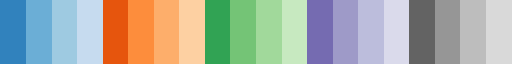

In [356]:
cmap

In [361]:

# bar plot figure
# color_map_ = {
#     f'{our_model_name} ($n_h^{{sa}}=1, n_h^{{ra}}=1$)': cmap(8), # purple
#     f'{our_model_name} ($n_h^{{sa}}=0, n_h^{{ra}}=2$)': cmap(0), # blue
#     f'{our_model_name} [asymmetric] ($n_h^{{sa}}=1, n_h^{{ra}}=1$)': cmap(8), # purple
#     f'{our_model_name} [asymmetric] ($n_h^{{sa}}=0, n_h^{{ra}}=2$)': cmap(0), # blue
#     'Transformer ($n_h^{sa}=2, n_h^{ra}=0$)': cmap(6), # red
#     "Abstractor's RCA ($n_h^{{sa}}=1, n_h^{{ra}}=1$)": cmap(8),
#     "Abstractor's RCA ($n_h^{{sa}}=0, n_h^{{ra}}=2$)": cmap(0),
#     # 'Transformer+': cmap(4),
#     }

cmap = sns.color_palette('tab20c', as_cmap=True)
color_map_ = {
    f'{transformer_name} ($n_h^{{sa}}=8, n_h^{{ra}}=0$) [481K]': cmap(4),
    # f'{transformer_name} ($n_h^{{sa}}=4, n_h^{{ra}}=0$) [481K]': cmap(),
    f'{transformer_name} ($n_h^{{sa}}=2, n_h^{{ra}}=0$) [481K]': cmap(5),
    f'{transformer_name} ($n_h^{{sa}}=8, n_h^{{ra}}=0$) [386K]': cmap(6),
    f'{transformer_name} ($n_h^{{sa}}=2, n_h^{{ra}}=0$) [386K]': cmap(7),
    # f'{transformer_name} ($n_h^{{sa}}=4, n_h^{{ra}}=0$) [386K]': cmap(),
    f'{transformer_name} [Symmetric] ($n_h^{{sa}}=2, n_h^{{ra}}=0$) [354K]': cmap(7),
    f'{transformer_name} [Symmetric] ($n_h^{{sa}}=2, n_h^{{ra}}=0$) [440K]': cmap(5),

    '$T$ [Symmetric SA] ($n_h^{sa}=2, n_h^{ra}=0$) [354K]': cmap(7),
    '$T$ [Symmetric SA] ($n_h^{sa}=2, n_h^{ra}=0$) [440K]': cmap(5),
    '$T$ [Symmetric SA] ($n_h^{sa}=2, n_h^{ra}=0$) [481K]': cmap(4),
    '$T$ [Symmetric SA] ($n_h^{sa}=4, n_h^{ra}=0$) [440K]': cmap(6),
    '$T$ [Symmetric SA] ($n_h^{sa}=8, n_h^{ra}=0$) [440K]': cmap(8),

    "Abstractor's RCA [Asymmetric] ($n_h^{sa}=1, n_h^{ra}=1$) [371K]": cmap(12),
    "Abstractor's RCA [Asymmetric] ($n_h^{sa}=0, n_h^{ra}=2$) [388K]": cmap(0),


    f'{our_model_name} [Asymmetric] ($n_h^{{sa}}=0, n_h^{{ra}}=2$) [454K]': cmap(0),
    f'{our_model_name} [Asymmetric] ($n_h^{{sa}}=1, n_h^{{ra}}=1$) [437K]': cmap(12),
    f'{our_model_name} ($n_h^{{sa}}=0, n_h^{{ra}}=2$) [421K]': cmap(0),
    f'{our_model_name} ($n_h^{{sa}}=1, n_h^{{ra}}=1$) [404K]': cmap(12),

    '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=0, n_h^{ra}=2$) [388K]': cmap(1),
    '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=1, n_h^{ra}=1$) [355K]': cmap(13),
    '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=4, n_h^{ra}=4$) [356K]': cmap(14),
    '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=0, n_h^{ra}=8$) [390K]': cmap(2),
    '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=2, n_h^{ra}=2$) [356K]': cmap(15),

    # 'Dual-Attn Transformer [Asymmetric] ($n_h^{sa}=0, n_h^{ra}=2$) [454K]': cmap(0),
    # 'Dual-Attn Transformer [Asymmetric] ($n_h^{sa}=1, n_h^{ra}=1$) [437K]': cmap(12),
    # 'Dual-Attn Transformer ($n_h^{sa}=1, n_h^{ra}=1$) [404K]': cmap(12),
    # 'Dual-Attn Transformer ($n_h^{sa}=0, n_h^{ra}=2$) [421K]': cmap(0),
    # 'Dual-Attn Transformer [Asymmetric] ($n_h^{sa}=0, n_h^{ra}=4$) [421K]': cmap(),
    # 'Dual-Attn Transformer [Asymmetric] ($n_h^{sa}=2, n_h^{ra}=2$) [404K]': cmap(),
    # 'Dual-Attn Transformer [Asymmetric] ($n_h^{sa}=4, n_h^{ra}=4$) [405K]': cmap(),
    # 'Dual-Attn Transformer [Asymmetric] ($n_h^{sa}=4, n_h^{ra}=4$) [232K]': cmap(),
    # 'Dual-Attn Transformer [Asymmetric] ($n_h^{sa}=0, n_h^{ra}=8$) [241K]': cmap(),
    # 'Dual-Attn Transformer [Asymmetric] ($n_h^{sa}=0, n_h^{ra}=8$) [423K]': cmap()
    'Abstractor [469K]': cmap(8),
    'CoRelNet [215K]': cmap(16),
    'PrediNet [376K]': cmap(12),

}
model_order = [
    '$DAT$ ($n_h^{sa}=0, n_h^{ra}=2$) [421K]',
    '$DAT$ ($n_h^{sa}=1, n_h^{ra}=1$) [404K]',
    '$DAT$ [Asymmetric] ($n_h^{sa}=0, n_h^{ra}=2$) [454K]',
    '$DAT$ [Asymmetric] ($n_h^{sa}=1, n_h^{ra}=1$) [437K]',

    '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=0, n_h^{ra}=2$) [388K]',
    '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=1, n_h^{ra}=1$) [355K]',
    '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=2, n_h^{ra}=2$) [356K]',
    '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=4, n_h^{ra}=4$) [356K]',
    '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=0, n_h^{ra}=8$) [390K]',

    "Abstractor's RCA [Asymmetric] ($n_h^{sa}=1, n_h^{ra}=1$) [371K]",
    "Abstractor's RCA [Asymmetric] ($n_h^{sa}=0, n_h^{ra}=2$) [388K]",

    '$T$ ($n_h^{sa}=8, n_h^{ra}=0$) [481K]',
    '$T$ ($n_h^{sa}=2, n_h^{ra}=0$) [481K]',

    '$T$ [Symmetric SA] ($n_h^{sa}=2, n_h^{ra}=0$) [354K]',
    '$T$ [Symmetric SA] ($n_h^{sa}=2, n_h^{ra}=0$) [440K]',
    '$T$ [Symmetric SA] ($n_h^{sa}=2, n_h^{ra}=0$) [481K]',
    '$T$ [Symmetric SA] ($n_h^{sa}=4, n_h^{ra}=0$) [440K]',
    '$T$ [Symmetric SA] ($n_h^{sa}=8, n_h^{ra}=0$) [440K]',

    '$T$ ($n_h^{sa}=8, n_h^{ra}=0$) [386K]',
    '$T$ ($n_h^{sa}=2, n_h^{ra}=0$) [386K]',
    'PrediNet [376K]',
    'CoRelNet [215K]',
    'Abstractor [469K]',
    ]

figure_data['Model'] = pd.Categorical(figure_data.apply(get_name, axis=1), model_order, ordered=True)

In [363]:
list(figure_data.Model.unique())

['$DAT$ [Symmetric SA,RA] ($n_h^{sa}=0, n_h^{ra}=8$) [390K]',
 '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=4, n_h^{ra}=4$) [356K]',
 '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=2, n_h^{ra}=2$) [356K]',
 '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=0, n_h^{ra}=2$) [388K]',
 '$DAT$ [Symmetric SA,RA] ($n_h^{sa}=1, n_h^{ra}=1$) [355K]',
 '$T$ [Symmetric SA] ($n_h^{sa}=4, n_h^{ra}=0$) [440K]',
 '$T$ [Symmetric SA] ($n_h^{sa}=8, n_h^{ra}=0$) [440K]',
 '$T$ [Symmetric SA] ($n_h^{sa}=2, n_h^{ra}=0$) [354K]',
 '$T$ [Symmetric SA] ($n_h^{sa}=2, n_h^{ra}=0$) [440K]',
 '$T$ [Symmetric SA] ($n_h^{sa}=2, n_h^{ra}=0$) [481K]',
 '$T$ ($n_h^{sa}=8, n_h^{ra}=0$) [481K]',
 '$T$ ($n_h^{sa}=2, n_h^{ra}=0$) [481K]',
 '$T$ ($n_h^{sa}=8, n_h^{ra}=0$) [386K]',
 '$T$ ($n_h^{sa}=2, n_h^{ra}=0$) [386K]',
 "Abstractor's RCA [Asymmetric] ($n_h^{sa}=1, n_h^{ra}=1$) [371K]",
 "Abstractor's RCA [Asymmetric] ($n_h^{sa}=0, n_h^{ra}=2$) [388K]",
 '$DAT$ [Asymmetric] ($n_h^{sa}=0, n_h^{ra}=2$) [454K]',
 '$DAT$ [Asymmetric] ($n_h^{sa}=1, n_h^{ra}=

### DAT vs T

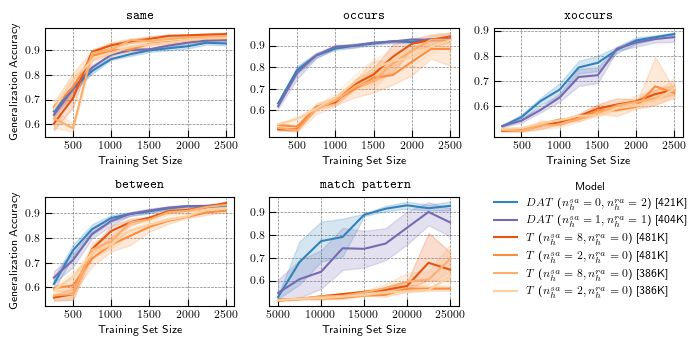

In [ ]:
fig = plt.figure(figsize=(7,3.5))

fig_models = [
    'sa=2; d=128; L=2',
    # 'sa=2; d=128; L=2',
    'sa=2; d=144; L=2',
    # 'sa=4; d=128; L=2',
    # 'sa=4; d=144; L=2',
    'sa=8; d=128; L=2',
    'sa=8; d=144; L=2',
    'sa=1; rca=1; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    # 'sa=1; ra=1; d=128; L=2; ra_type=rel_attn; sym_rel=True; symbol_type=positional_symbols',
    # 'sa=0; ra=2; d=128; L=2; ra_type=rel_attn; sym_rel=True; symbol_type=positional_symbols',
    # 'sa=1; ra=1; d=128; L=2; ra_type=rel_attn; sym_rel=False; symbol_type=positional_symbols',
    # 'sa=0; ra=2; d=128; L=2; ra_type=rel_attn; sym_rel=False; symbol_type=positional_symbols',
    # 'sa=1; ra=1; d=128; L=2; ra_type=rca; sym_rel=False; symbol_type=positional_symbols',
    # 'sa=0; ra=2; d=128; L=2; ra_type=rca; sym_rel=False; symbol_type=positional_symbols',
    ]
model_filter = figure_data.model_name.isin(fig_models)

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter & model_filter]
    # config filter
    # ax_data = ax_data[ax_data['Symmetric RA']!=False]
    fig_model_order = [m for m in model_order if m in list(ax_data['Model'].unique())]
    ax_data['Model'] = pd.Categorical(ax_data['Model'], fig_model_order, ordered=True)

    ax = fig.add_subplot(2, 3, i+1)
    # last = (i==len(tasks)-1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_yticks([0.6, 0.7, 0.8, 0.9])
    ax.set_title(task)
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(1.5, 0), fontsize='small', title='Model', frameon=False)
fig.legend(handles=ax.get_lines(), labels=fig_model_order,  loc=(0.7, 0.125), fontsize='medium', title='Model', frameon=False)
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/relgames/relgames_learning_curves_transformer_comparison.pdf')

### DAT v Baselines

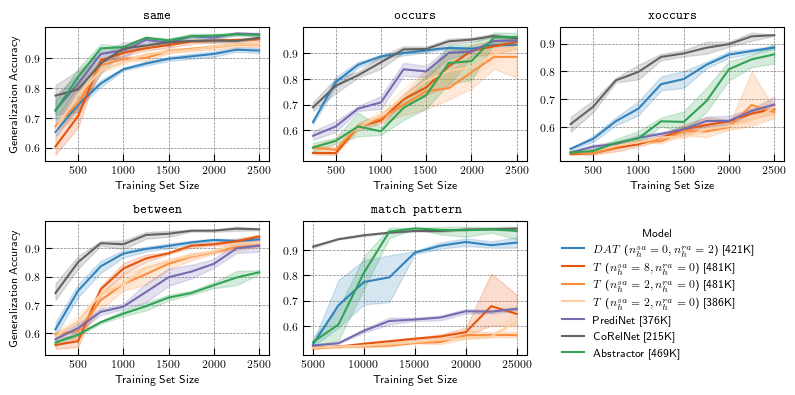

In [253]:
fig = plt.figure(figsize=(8,4))

fig_models = [
    'sa=2; d=128; L=2',
    'sa=2; d=144; L=2',
    # 'sa=4; d=128; L=2',
    # 'sa=4; d=144; L=2',
    # 'sa=8; d=128; L=2',
    'sa=8; d=144; L=2',
    # 'sa=1; ra=1; d=128; L=2; ra_type=rel_attn; sym_rel=True; symbol_type=positional_symbols',
    # 'sa=0; ra=2; d=128; L=2; ra_type=rel_attn; sym_rel=True; symbol_type=positional_symbols',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'corelnet',
    'predinet',
    'abstractor',
    # 'sa=1; ra=1; d=128; L=2; ra_type=rel_attn; sym_rel=False; symbol_type=positional_symbols',
    # 'sa=0; ra=2; d=128; L=2; ra_type=rel_attn; sym_rel=False; symbol_type=positional_symbols',
    # 'sa=1; ra=1; d=128; L=2; ra_type=rca; sym_rel=False; symbol_type=positional_symbols',
    # 'sa=0; ra=2; d=128; L=2; ra_type=rca; sym_rel=False; symbol_type=positional_symbols',
    ]
model_filter = figure_data.model_name.isin(fig_models)

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter & model_filter]
    # config filter
    # ax_data = ax_data[ax_data['Symmetric RA']!=False]
    fig_model_order = [m for m in model_order if m in list(ax_data['Model'].unique())]
    ax_data['Model'] = pd.Categorical(ax_data['Model'], fig_model_order, ordered=True)

    ax = fig.add_subplot(2, 3, i+1)
    # last = (i==len(tasks)-1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_yticks([0.6, 0.7, 0.8, 0.9])
    ax.set_title(task)
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(1.5, 0), fontsize='small', title='Model', frameon=False)
fig.legend(handles=ax.get_lines(), labels=fig_model_order,  loc=(0.7, 0.08), fontsize='medium', title='Model', frameon=False)
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/relgames/relgames_learning_curves_baseline_comparisons.pdf')

### Symmetry of RA Ablation

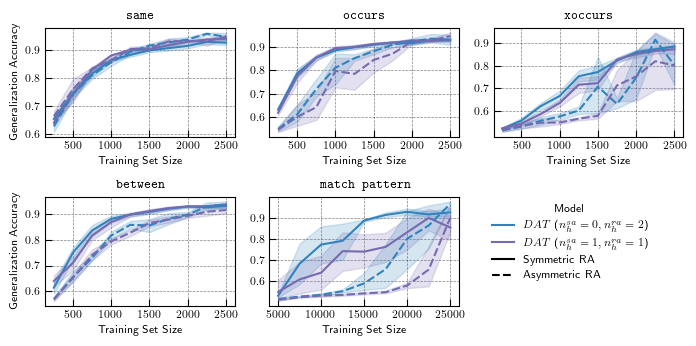

In [254]:
fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter]
    # config filter
    ax_data = ax_data[ax_data['rca_type']=='disentangled_v2']
    ax_data = ax_data[~ax_data['Symmetric RA'].isna()]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model',
        style='Symmetric RA', style_order=[True, False], legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    ax.set_yticks([0.6, 0.7, 0.8, 0.9])
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.65, 0.15), fontsize='medium', title='Model')
# create custom legend
from matplotlib.lines import Line2D
legend_elements = [*ax.get_lines()[:2], Line2D([0], [0], color='black', linestyle='-', label='Symmetric RA'), Line2D([0], [0], color='black', linestyle='--', label='Asymmetric RA')]
legend_labels = ['$DAT$ ($n_h^{sa}=0, n_h^{ra}=2$)', '$DAT$ ($n_h^{sa}=1, n_h^{ra}=1$)', 'Symmetric RA', 'Asymmetric RA']

fig.legend(handles=legend_elements, labels=legend_labels,  loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
fig.set_tight_layout(True)
# fig.savefig(f'{save_dir}/relgames/relgames_learning_curves_symmetry_ablation.pdf')

### Symmetry of SA Ablation

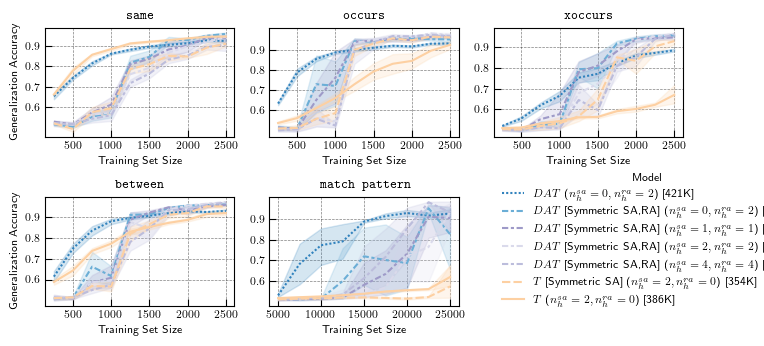

In [368]:
fig = plt.figure(figsize=(7,3.5))

fig_models = [
    'sa=2; d=128; L=2',
    'sa=2; d=128; L=2; sym_attn',
    # 'sa=2; d=144; L=2; sym_attn',
    'sa=0; rca=2; d=128; L=2; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_sym_retriever',
    'sa=2; ra=2; nr=4; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
    'sa=1; ra=1; nr=2; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
    'sa=4; ra=4; nr=8; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
    'sa=0; ra=2; nr=2; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
    # 'sa=0; ra=8; nr=8; d=128; L=2; ra_type=relational_attention; sym_rel=True; sym_attn=True; symbol_type=positional_symbols',
    ]
model_filter = figure_data.model_name.isin(fig_models)

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter & model_filter]
    # config filter
    # ax_data = ax_data[ax_data['Symmetric RA']!=False]
    fig_model_order = [m for m in model_order if m in list(ax_data['Model'].unique())]
    ax_data['Model'] = pd.Categorical(ax_data['Model'], fig_model_order, ordered=True)

    ax = fig.add_subplot(2, 3, i+1)
    # last = (i==len(tasks)-1)
    sns.lineplot(
        ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model', legend=False, 
        palette=color_map_, style='Symmetry',
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_yticks([0.6, 0.7, 0.8, 0.9])
    ax.set_title(task)
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# sns.move_legend(ax, loc='lower center', bbox_to_anchor=(1.5, 0), fontsize='small', title='Model', frameon=False)
fig.legend(handles=axes[0].get_lines(), labels=fig_model_order,  loc=(0.65, 0.1), fontsize='medium', title='Model', frameon=False)
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/relgames/relgames_learning_curves_attn_symmetry_ablation.pdf')

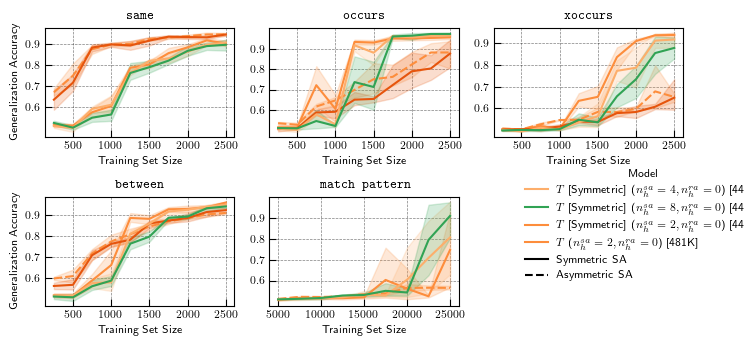

In [218]:
fig = plt.figure(figsize=(7,3.5))

fig_models = [
    # 'sa=2; d=128; L=2',
    # 'sa=2; d=128; L=2',
    # 'sa=2; d=128; L=2; sym_attn',
    'sa=2; d=144; L=2',
    'sa=2; d=144; L=2; sym_attn',
    'sa=4; d=144; L=2; sym_attn',
    'sa=8; d=144; L=2; sym_attn',
    # 'sa=4; d=128; L=2',
    # 'sa=4; d=144; L=2',
    # 'sa=8; d=128; L=2',
    # 'sa=8; d=144; L=2',
    ]
model_filter = figure_data.model_name.isin(fig_models)

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter & model_filter]
    # config filter
    # ax_data = ax_data[ax_data['rca_type'].isna()]
    # ax_data = ax_data[~ax_data['Symmetric RA'].isna()]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model',
        style='Symmetric SA', style_order=[True, False], legend=False, palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    ax.set_yticks([0.6, 0.7, 0.8, 0.9])
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.65, 0.15), fontsize='medium', title='Model')
# create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    # *ax.get_lines()[:len(ax_data.Model.unique())],
    *[Line2D([0], [0], color=color_map_[m], linestyle='-', label=m) for m in ax_data.Model.unique().tolist()],
    Line2D([0], [0], color='black', linestyle='-', label='Symmetric SA'),
    Line2D([0], [0], color='black', linestyle='--', label='Asymmetric SA')]
legend_labels = [
    # '$T$ ($n_h^{sa}=2, n_h^{ra}=0$)',
    *ax_data.Model.unique().tolist(),
    'Symmetric SA', 'Asymmetric SA']

fig.legend(handles=legend_elements, labels=legend_labels,  loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/relgames/relgames_learning_curves_selfattn_symmetry_ablation.pdf')

In [ ]:
# as of now, symmetry of SA makes Transformer somewhat better on occurs and xoccurs but worse and same and between; makes no significant difference on match pattern...

### RelAttn vs Abstractor RCA

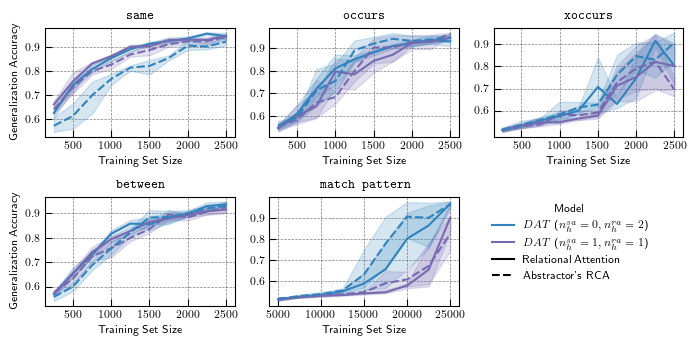

In [167]:
fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    # task filter
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter]
    # config filter
    ax_data = ax_data[ax_data['Symmetric RA']==False]

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Training Set Size', y='Generalization Accuracy', hue='Model',
        style='rca_type', style_order=['disentangled_v2', 'standard'], legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    ax.set_yticks([0.6, 0.7, 0.8, 0.9])
    if (i%3) != 0:
        ax.set_ylabel('')
    axes.append(ax)

# fig.legend(handles=ax.get_lines(), labels=models,  loc=(0.65, 0.15), fontsize='medium', title='Model')
# create custom legend
from matplotlib.lines import Line2D
legend_elements = [*ax.get_lines()[:2], Line2D([0], [0], color='black', linestyle='-', label='Symmetric RA'), Line2D([0], [0], color='black', linestyle='--', label='Asymmetric RA')]
# legend_labels = ['$n_h^{{sa}}=1, n_h^{{ra}}=1$', '$n_h^{{sa}}=0, n_h^{{ra}}=2$', 'Disentangled Relational Attention', "Abstractor's RCA"]
legend_labels = [f'{our_model_name} ($n_h^{{sa}}=0, n_h^{{ra}}=2$)', f'{our_model_name} ($n_h^{{sa}}=1, n_h^{{ra}}=1$)', 'Relational Attention', "Abstractor's RCA"]

fig.legend(handles=legend_elements, labels=legend_labels,  loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
fig.set_tight_layout(True)
# fig.savefig(f'{save_dir}/relgames/relgames_learning_curves_rcatype_ablation.pdf')

## Math

In [15]:
our_model_name = '$DAT$'
transformer_name = 'Transformer'

In [16]:
# temporary while runs are moved
figure_data = pd.read_csv('figure_data/math/run_history_all.csv')

# figure_data1 = pd.read_csv('figure_data/math/run_history_all.csv')
# figure_data2 = pd.read_csv('figure_data_tmp/math/run_history_all.csv')
# figure_data = pd.concat([figure_data1, figure_data2])

C:\Users\awnya\AppData\Local\Temp\ipykernel_8528\4078261913.py:2: DtypeWarning: Columns (16,24) have mixed types. Specify dtype option on import or set low_memory=False.
  figure_data = pd.read_csv('figure_data/math/run_history_all.csv')


In [17]:
figure_data.columns

Index(['interpolate_loss', 'interpolate_teacher_forcing_acc',
       'interpolate_perplexity', 'train_loss', 'epoch', '_timestamp',
       'extrapolate_loss', 'trainer/global_step', 'extrapolate_perplexity',
       '_runtime', '_step', 'train_teacher_forcing_acc',
       'extrapolate_teacher_forcing_acc', 'symbol_retrieval',
       'loss_ignore_idx', 'abstractor_kwargs', 'output_spec', 'out_block_size',
       'encoder_kwargs', 'decoder_kwargs', 'd_model', 'n_layers_dec',
       'in_block_size', 'n_layers_enc', 'input_spec', 'out_dim', 'group',
       'symbol_retrieval_kwargs', 'name', 'task'],
      dtype='object')

In [18]:
figure_data.group.unique()

array(['enc_sa=4; enc_ra=4; dec_sa=8; dec_ra=0; d_cross=8; d=128; el=4; dl=4',
       'enc_sa=4; enc_ra=4; dec_sa=4; dec_ra=4; d_cross=8; d=128; el=4; dl=4',
       'enc_sa=4; enc_ra=4; dec_sa=8; dec_ra=0; d_cross=8; d=128; el=3; dl=3',
       'enc_sa=4; enc_ra=4; dec_sa=4; dec_ra=4; d_cross=8; d=128; el=3; dl=3',
       'enc_sa=8; enc_ra=0; dec_sa=8; dec_ra=0; d_cross=8; d=144; el=4; dl=4',
       'enc_sa=8; enc_ra=0; dec_sa=8; dec_ra=0; d_cross=8; d=144; el=3; dl=3',
       'Abstractor - L=2, d=128, h=8', 'Abstractor - L=1, d=128, h=8',
       'enc_sa=8; enc_ra=0; dec_sa=8; dec_ra=0; dec_cross=8; d=128; ra_type=NA, symbol_type=NA; el=2; dl=2',
       'enc_sa=4; enc_ra=4; dec_sa=4; dec_ra=4; dec_cross=8; d=128; ra_type=rel_attn, symbol_type=position_relative; el=2; dl=2',
       'enc_sa=4; enc_ra=4; dec_sa=8; dec_ra=0; dec_cross=8; d=128; ra_type=rel_attn, symbol_type=position_relative; el=2; dl=2',
       'enc_sa=8; enc_ra=0; dec_sa=8; dec_ra=0; dec_cross=8; d=144; ra_type=NA, symbol

In [22]:
import re
def parse_model_name(group_name):
    # format: enc_sa=8; enc_ra=0; dec_sa=8; dec_ra=0; dec_cross=8; d=128; ra_type=NA, symbol_type=NA; el=2; dl=2
    # extract enc_sa, enc_ra, d, el, etc.
    regex_exprs = [r'enc_sa=(\d+)', r'enc_ra=(\d+)', r'dec_sa=(\d+)', r'dec_ra=(\d+)', r'dec_cross=(\d+)', r'd=(\d+)', r'ra_type=(\w+)', r'symbol_type=(\w+)', r'el=(\d+)', r'dl=(\d+)']
    inferred_config_vals = []

    for expr in regex_exprs:
        match = re.search(expr, group_name)
        if match:
            inferred_config_vals.append(match.group(1))
        else:
            inferred_config_vals.append(None)

    return tuple(inferred_config_vals)

figure_data['enc_sa'], figure_data['enc_ra'], figure_data['dec_sa'], figure_data['dec_ra'], figure_data['dec_cross'], figure_data['d'], figure_data['ra_type'], figure_data['symbol_type'], figure_data['el'], figure_data['dl'] = zip(*figure_data['group'].apply(parse_model_name))

In [24]:
models = {
    'enc_sa=8; enc_ra=0; dec_sa=8; dec_ra=0; dec_cross=8; d=128; ra_type=NA, symbol_type=NA; el=2; dl=2': f'{transformer_name} [692K]',
    # 'ee=8; ea=0; de=8; da=0; dc=8; el=2; dl=2': 'Transformer',
    'enc_sa=8; enc_ra=0; dec_sa=8; dec_ra=0; dec_cross=8; d=144; ra_type=NA, symbol_type=NA; el=2; dl=2': f'{transformer_name} [871K]',
    'enc_sa=8; enc_ra=0; dec_sa=8; dec_ra=0; d_cross=8; d=144; el=3; dl=3': f'{transformer_name} [1.3M]',
    'enc_sa=8; enc_ra=0; dec_sa=8; dec_ra=0; d_cross=8; d=144; el=4; dl=4': f'{transformer_name} [1.7M]',
    'enc_sa=4; enc_ra=4; dec_sa=8; dec_ra=0; dec_cross=8; d=128; ra_type=rel_attn, symbol_type=position_relative; el=2; dl=2': f'{our_model_name} [783K]',
    'enc_sa=4; enc_ra=4; dec_sa=4; dec_ra=4; dec_cross=8; d=128; ra_type=rel_attn, symbol_type=position_relative; el=2; dl=2': f'{our_model_name} [832K]',
    'enc_sa=4; enc_ra=4; dec_sa=4; dec_ra=4; d_cross=8; d=128; el=4; dl=4': f'{our_model_name} [1.46M]',
    'enc_sa=4; enc_ra=4; dec_sa=8; dec_ra=0; d_cross=8; d=128; el=4; dl=4': f'{our_model_name} [1.43M]',
    'enc_sa=4; enc_ra=4; dec_sa=4; dec_ra=4; d_cross=8; d=128; el=3; dl=3': f'{our_model_name} [1.11M]',
    'enc_sa=4; enc_ra=4; dec_sa=8; dec_ra=0; d_cross=8; d=128; el=3; dl=3': f'{our_model_name} [1.09M]',
    'Abstractor - L=1, d=128, h=8': 'Abstractor [816K]',
    'Abstractor - L=2, d=128, h=8': 'Abstractor [1.54M]',
    # 'e_sa=4; e_rca=4; d_sa=8; d_rca=0; d_cross=8; rca_dis=True, el=2; dl=2': 'AbstractTransformer (v1; OGRCA)',
    # 'e_sa=4; e_rca=4; d_sa=4; d_rca=4; d_cross=8; rca_dis=True, el=2; dl=2': 'AbstractTransformer (v2; OGRCA)',
    }

In [25]:
figure_data.rename(columns={
    'epoch': 'Epoch', 'interpolate_teacher_forcing_acc': 'Accuracy (Interpolation)', 'extrapolate_teacher_forcing_acc': 'Accuracy (Extrapolation)', 
    'train_teacher_forcing_acc': 'Accuracy (Training)', 'task': 'Task', 'group': 'Model'}, inplace=True)

def format_task(task):
    string = task.replace('_', r'\_')
    string = r"$\texttt{" + string + r"}$"
    return string
figure_data['Task'] = pd.Categorical(figure_data['Task'].map(format_task))
figure_data = figure_data[figure_data['Model'].isin(models.keys())]
figure_data['Model'] = pd.Categorical(figure_data['Model'].map(models), models.values(), ordered=True)

In [26]:
# TODO: need to run more trials for some, etc.
figure_data.groupby(['Model', 'Task'])['Accuracy (Training)'].aggregate('count')

Model               Task                                      
Transformer [692K]  $\texttt{algebra\_\_linear\_1}$               400
                    $\texttt{algebra\_\_sequence\_next\_term}$    400
                    $\texttt{calculus\_\_differentiate}$          400
                    $\texttt{polynomials\_\_add}$                 400
                    $\texttt{polynomials\_\_expand}$              400
Transformer [871K]  $\texttt{algebra\_\_linear\_1}$               500
                    $\texttt{algebra\_\_sequence\_next\_term}$    500
                    $\texttt{calculus\_\_differentiate}$          500
                    $\texttt{polynomials\_\_add}$                 500
                    $\texttt{polynomials\_\_expand}$              500
Transformer [1.3M]  $\texttt{algebra\_\_linear\_1}$               600
                    $\texttt{algebra\_\_sequence\_next\_term}$    800
                    $\texttt{calculus\_\_differentiate}$          800
                    $\textt

### DAT vs T figures

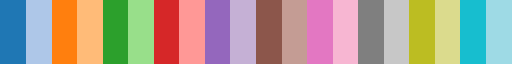

In [71]:
sns.color_palette('tab20', as_cmap=True)

In [72]:
cmap = sns.color_palette('tab20', as_cmap=True)
color_map_ = {
    f'{our_model_name} [832K]': cmap(8), # purple
    f'{our_model_name} [783K]': cmap(0), # blue
    f'{transformer_name} [692K]': cmap(7), # lighter red
    f'{transformer_name} [871K]': cmap(6), # red # NOTE: removed Transformer+ for now
    # 'Abstractor [816K]': cmap(13),
    # 'Abstractor [1.54M]': cmap(12),
    # f'{our_model_name} [1.46M]': cmap(0),
    # f'{our_model_name} [1.43M]': cmap(0),
    # f'{our_model_name} [1.11M]': cmap(0),
    # f'{our_model_name} [1.09M]': cmap(0),
    # 'Transformer': cmap(6), # red
    # 'Transformer+': cmap(4),
    }

model_selection = [
    f'{our_model_name} [832K]',
    f'{our_model_name} [783K]',
    f'{transformer_name} [692K]',
    f'{transformer_name} [871K]',
    # 'Abstractor [816K]',
    # 'Abstractor [1.54M]',
    # f'{our_model_name} [1.46M]'
    # f'{our_model_name} [1.43M]'
    # f'{our_model_name} [1.11M]'
    # f'{our_model_name} [1.09M]'
]

model_filter = figure_data['Model'].isin(model_selection)

In [73]:
# import Line2D
from matplotlib.lines import Line2D

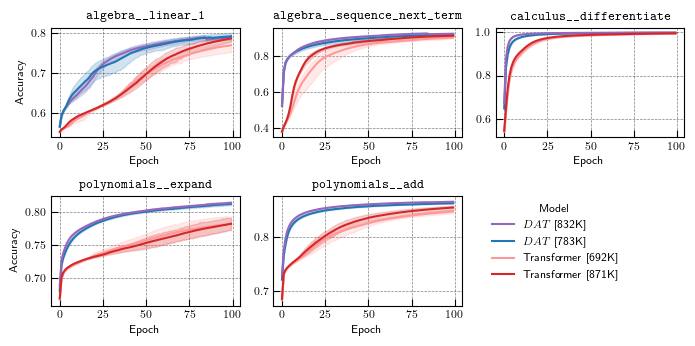

In [74]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter & model_filter]
    ax_data['Model'] = ax_data['Model'].astype('str')

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Training)', hue='Model', legend=False, palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
fig.legend(handles=[Line2D([0], [0], color=c, linestyle='-', label=l) for l, c in color_map_.items()],
    loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.75, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_trainacc.pdf')

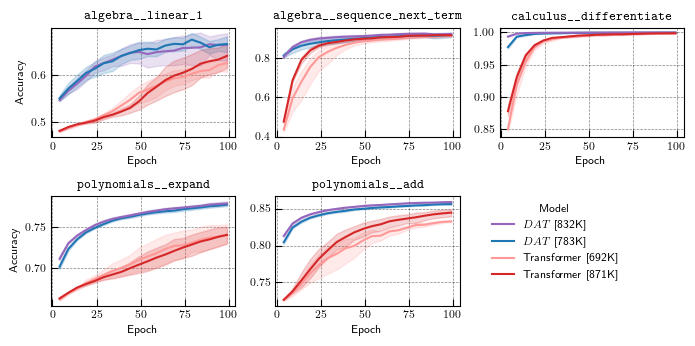

In [75]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter & model_filter]
    ax_data['Model'] = ax_data['Model'].astype('str')

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Interpolation)', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
fig.legend(handles=[Line2D([0], [0], color=c, linestyle='-', label=l) for l, c in color_map_.items()],
    loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.75, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_interpolation.pdf')

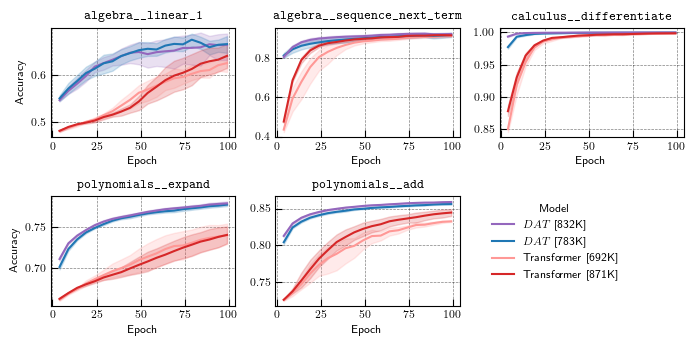

In [76]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter & model_filter]
    ax_data['Model'] = ax_data['Model'].astype('str')

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Extrapolation)', hue='Model', legend=False,  palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
fig.legend(handles=[Line2D([0], [0], color=c, linestyle='-', label=l) for l, c in color_map_.items()],
    loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.75, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_extrapolation.pdf')

### DAT vs Transformer, varying \# of layers figures

In [27]:
cmap = sns.color_palette('tab20c', as_cmap=True)
color_map_ = {
    f'{transformer_name} [692K]': cmap(5), # lighter red
    f'{our_model_name} [783K]': cmap(2),
    # 'Abstractor [816K]': cmap(9),
    f'{transformer_name} [871K]': cmap(6), # red
    f'{our_model_name} [1.09M]': cmap(1),
    f'{transformer_name} [1.3M]': cmap(5),
    f'{our_model_name} [1.43M]': cmap(0),
    # 'Abstractor [1.54M]': cmap(8),
    f'{transformer_name} [1.7M]': cmap(4),
    # f'{our_model_name} [832K]': cmap(2),
    # f'{our_model_name} [1.11M]': cmap(1),
    # f'{our_model_name} [1.46M]': cmap(0),
    # 'Transformer': cmap(6), # red
    # 'Transformer+': cmap(4),
    }

model_selection = list(color_map_.keys())

model_filter = figure_data['Model'].isin(model_selection)

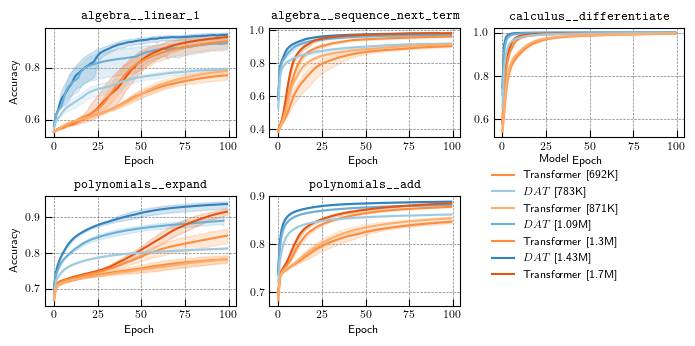

In [79]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter & model_filter]
    ax_data['Model'] = ax_data['Model'].astype('str')

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Training)', hue='Model', legend=False, palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
fig.legend(handles=[Line2D([0], [0], color=c, linestyle='-', label=l) for l, c in color_map_.items()],
    loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.75, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_varied_depth_trainacc.pdf')

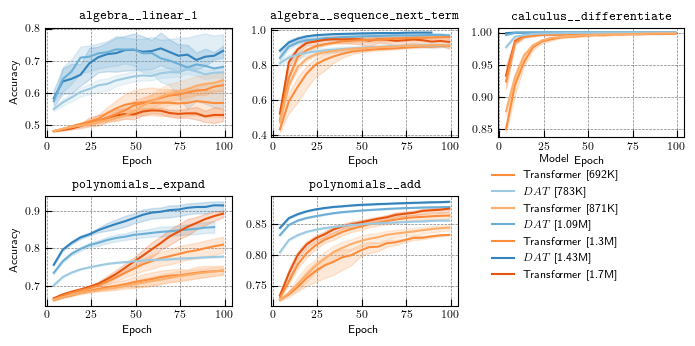

In [81]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter & model_filter]
    ax_data['Model'] = ax_data['Model'].astype('str')

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Interpolation)', hue='Model', legend=False, palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
fig.legend(handles=[Line2D([0], [0], color=c, linestyle='-', label=l) for l, c in color_map_.items()],
    loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.75, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_varied_depth_interpolation.pdf')

In [93]:
figure_data[r'$d_{\text{model}}$'] = figure_data['d']
figure_data[r'Encoder $n_h^{sa}$'] = figure_data['enc_sa']
figure_data[r'Encoder $n_h^{ra}$'] = figure_data['enc_ra']
figure_data[r'Decoder $n_h^{sa}$'] = figure_data['dec_sa']
figure_data[r'Decoder $n_h^{ra}$'] = figure_data['dec_ra']
figure_data['# Layers'] = figure_data['n_layers_dec']
config_cols = ['# Layers', r'$d_{\text{model}}$', 'Encoder $n_h^{sa}$', 'Encoder $n_h^{ra}$', 'Decoder $n_h^{sa}$', 'Decoder $n_h^{ra}$']

depth_comparison_table = figure_data[figure_data.Epoch == figure_data.Epoch.max()][['Task', 'Model'] + config_cols + ['Accuracy (Interpolation)']].dropna()
depth_comparison_table['Model'] = pd.Categorical(depth_comparison_table['Model'], model_selection, ordered=True)

depth_comparison_table['Parameter Count'] = depth_comparison_table.Model.apply(lambda x: x.split('[')[1][:-1].strip())

depth_comparison_table['Model'] = depth_comparison_table['Model'].apply(lambda x: x.split('[')[0].strip())

# depth_comparison_table.groupby(['Task', 'Model']).aggregate(['mean', 'sem'])
depth_comparison_table = depth_comparison_table.groupby(['Task', 'Model', 'Parameter Count'] + config_cols).aggregate(['mean', 'sem', 'count'])
depth_comparison_table[[('Accuracy (Interpolation)', 'mean'), ('Accuracy (Interpolation)', 'sem')]] = depth_comparison_table[[('Accuracy (Interpolation)', 'mean'), ('Accuracy (Interpolation)', 'sem')]] * 100 # convert to percentage
depth_comparison_table = depth_comparison_table.dropna()
depth_comparison_table.round(1)

Accuracy (Interpolation)  \
                                                                                                                                                                                                   mean   
Task                                       Model       Parameter Count # Layers $d_{\text{model}}$ Encoder $n_h^{sa}$ Encoder $n_h^{ra}$ Decoder $n_h^{sa}$ Decoder $n_h^{ra}$                            
$\texttt{algebra\_\_linear\_1}$            $DAT$       783K            2        128                4                  4                  8                  0                                      66.5   
                                                       1.09M           3        128                4                  4                  8                  0                                      68.1   
                                                       1.43M           4        128                4                  4                  8                  0                                      73.1   
                                           Transformer 692K            2        128                8                  0                  8                  0                                      62.5   
                                                       871K            2        144                8                  0                  8                  0                                      64.0   
                                                       1.3M            3        144                8                  0                  8                  0                                      57.0   
                                                       1.7M            4        144                8                  0                  8                  0                                      53.2   
$\texttt{algebra\_\_sequence\_next\_term}$ $DAT$       783K            2        128                4                  4                  8                  0                                      91.6   
                                                       1.09M           3        128                4                  4                  8                  0                                      97.0   
                                           Transformer 692K            2        128                8                  0                  8                  0                                      91.1   
                                                       871K            2        144                8                  0                  8                  0                                      91.4   
                                                       1.3M            3        144                8                  0                  8                  0                                      96.1   
                                                       1.7M            4        144                8                  0                  8                  0                                      93.4   
$\texttt{calculus\_\_differentiate}$       $DAT$       783K            2        128                4                  4                  8                  0                                     100.0   
                                                       1.43M           4        128                4                  4                  8                  0                                     100.0   
                                           Transformer 692K            2        128                8                  0                  8                  0                                      99.9   
                                                       871K            2        144                8                  0                  8                  0                                      99.9   
                                                       1.3M            3        144                8               

In [95]:
depth_comparison_table['Accuracy'] = '$' + depth_comparison_table[('Accuracy (Interpolation)', 'mean')].round(1).astype(str) + ' \pm ' + depth_comparison_table[('Accuracy (Interpolation)', 'sem')].round(1).astype(str) + '$'
# depth_comparison_table.reset_index(drop=False, inplace=True)
# depth_comparison_table.set_index(['Task', 'Model', 'Parameter Count'], inplace=True)
# depth_comparison_table = depth_comparison_table[config_cols + ['Accuracy']].sort_index(level=[0,2])

depth_comparison_table = depth_comparison_table[['Accuracy']].sort_index(level=[0,2])

# Set NA rows for missing configurations
algebra_linear_index = [idx for idx in depth_comparison_table.index if idx[0]==r'$\texttt{algebra\_\_linear\_1}$']
for task in depth_comparison_table.index.get_level_values(0).unique():
    print(task)

    for idx in algebra_linear_index:
        idx = (task, *idx[1:])
        if not (idx in depth_comparison_table.index):
            depth_comparison_table.loc[idx] = [np.nan]

depth_comparison_table = depth_comparison_table[['Accuracy']].sort_index(level=[0,2])
depth_comparison_table

$\texttt{algebra\_\_linear\_1}$
$\texttt{algebra\_\_sequence\_next\_term}$
$\texttt{calculus\_\_differentiate}$
$\texttt{polynomials\_\_add}$
$\texttt{polynomials\_\_expand}$


Accuracy
                                                                                                                                                                                               
Task                                       Model       Parameter Count # Layers $d_{\text{model}}$ Encoder $n_h^{sa}$ Encoder $n_h^{ra}$ Decoder $n_h^{sa}$ Decoder $n_h^{ra}$                 
$\texttt{algebra\_\_linear\_1}$            Transformer 692K            2        128                8                  0                  8                  0                    $62.5 \pm 1.1$
                                           $DAT$       783K            2        128                4                  4                  8                  0                    $66.5 \pm 1.0$
                                           Transformer 871K            2        144                8                  0                  8                  0                    $64.0 \pm 1.5$
                                           $DAT$       1.09M           3        128                4                  4                  8                  0                    $68.1 \pm 6.5$
                                           Transformer 1.3M            3        144                8                  0                  8                  0                    $57.0 \pm 2.3$
                                           $DAT$       1.43M           4        128                4                  4                  8                  0                    $73.1 \pm 1.1$
                                           Transformer 1.7M            4        144                8                  0                  8                  0                    $53.2 \pm 1.1$
$\texttt{algebra\_\_sequence\_next\_term}$ Transformer 692K            2        128                8                  0                  8                  0                    $91.1 \pm 0.2$
                                           $DAT$       783K            2        128                4                  4                  8                  0                    $91.6 \pm 0.6$
                                           Transformer 871K            2        144                8                  0                  8                  0                    $91.4 \pm 0.2$
                                           $DAT$       1.09M           3        128                4                  4                  8                  0                    $97.0 \pm 0.5$
                                           Transformer 1.3M            3        144                8                  0                  8                  0                    $96.1 \pm 0.5$
                                           $DAT$       1.43M           4        128                4                  4                  8                  0                               NaN
                                           Transformer 1.7M            4        144                8                  0                  8                  0                    $93.4 \pm 2.0$
$\texttt{calculus\_\_differentiate}$       Transformer 692K            2        128                8                  0                  8                  0                    $99.9 \pm 0.0$
                                           $DAT$       783K            2        128                4                  4                  8                  0                   $100.0 \pm 0.0$
                                           Transformer 871K            2        144                8                  0                  8                  0                    $99.9 \pm 0.0$
                                           $DAT$       1.09M           3        128                4                  4                  8                  0                               NaN
                                           Transformer 1.3M            3        144                8                  0                  8             

In [96]:
# save to latex
confirm = input('confirm save to latex? (y/n)')
if confirm == 'y':
    col_format = 'l|l|' + 'c'* (len(config_cols) + 1) + '|c'
    depth_comparison_table.to_latex(f'{save_dir}/math/comparison_table.tex',
        multirow=True, escape=False, na_rep='--', float_format='%.1f\\%%', column_format=col_format)
    print('saved to latex')

saved to latex


C:\Users\awnya\AppData\Local\Temp\ipykernel_8528\1690733166.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  depth_comparison_table.to_latex(f'{save_dir}/math/comparison_table.tex',


In [12]:
figure_data['# Layers'] = figure_data['n_layers_dec']
depth_comparison_table = figure_data[figure_data.Epoch == figure_data.Epoch.max()][['Task', 'Model', '# Layers', 'Accuracy (Interpolation)']].dropna()
# depth_comparison_table['Model'] = pd.Categorical(depth_comparison_table['Model'], model_selection, ordered=True)

# keepe only DAT models with E=4/4, D=4/4 not E=4/4, D=8/0
model_remove = [f'{our_model_name} [783K]', f'{our_model_name} [1.43M]', f'{our_model_name} [1.09M]']
depth_comparison_table = depth_comparison_table[~depth_comparison_table['Model'].isin(model_remove)]

depth_comparison_table['Model Size (Parameter Count)'] = depth_comparison_table.Model.apply(lambda x: x.split('[')[1][:-1].strip())
def parse_param_count(param_ct_str):
    number = float(param_ct_str[:-1])
    unit = param_ct_str[-1]
    unit_map = dict(K=1e3, M=1e6)
    return int(number * unit_map[unit])
depth_comparison_table['Model Size (Parameter Count)'] = depth_comparison_table['Model Size (Parameter Count)'].apply(parse_param_count)

depth_comparison_table['Model'] = depth_comparison_table['Model'].apply(lambda x: x.split('[')[0].strip())
depth_comparison_table

,Task,Model,# Layers,Accuracy (Interpolation),Model Size (Parameter Count)
469,$\texttt{algebra\_\_linear\_1}$,$DAT$,4,0.822336,1460000
589,$\texttt{algebra\_\_linear\_1}$,$DAT$,4,0.629566,1460000
709,$\texttt{algebra\_\_linear\_1}$,$DAT$,4,0.846606,1460000
1189,$\texttt{algebra\_\_linear\_1}$,$DAT$,3,0.774840,1110000
1309,$\texttt{algebra\_\_linear\_1}$,$DAT$,3,0.768297,1110000
...,...,...,...,...,...
43068,$\texttt{polynomials\_\_add}$,Transformer,2,0.851401,871000
43188,$\texttt{polynomials\_\_add}$,Transformer,2,0.848200,871000
43308,$\texttt{polynomials\_\_add}$,Transformer,2,0.835539,871000
43428,$\texttt{polynomials\_\_add}$,Transformer,2,0.845818,871000


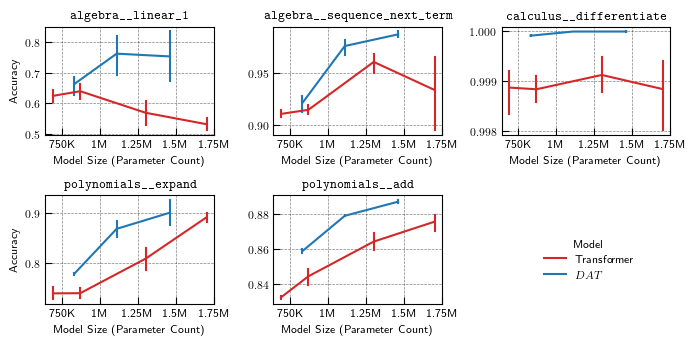

In [13]:
tasks = depth_comparison_table.Task.unique()
model_filter = depth_comparison_table.Model.isin([transformer_name, our_model_name])

cmap = sns.color_palette('tab20', as_cmap=True)
color_map_ = {
    transformer_name: cmap(6), # red
    our_model_name: cmap(0),
    # 'Abstractor': cmap(18),
    }

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = (depth_comparison_table.Task == task) & model_filter
    ax_data = depth_comparison_table.copy()[task_filter]
    ax_data['Model'] = ax_data['Model'].astype('str')

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Model Size (Parameter Count)', y='Accuracy (Interpolation)', hue='Model', legend=False, palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95), err_style='bars')
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

    ax.set_xticks([750e3, 1e6, 1.25e6, 1.5e6, 1.75e6], ['750K', '1M', '1.25M', '1.5M', '1.75M'])

# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
fig.legend(handles=[Line2D([0], [0], color=c, linestyle='-', label=l) for l, c in color_map_.items()],
    loc=(0.775, 0.175), fontsize='medium', title='Model', frameon=False)
# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.75, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_accuracy_scaling.pdf')

### DAT vs Abstractor, varying \# of layers figures

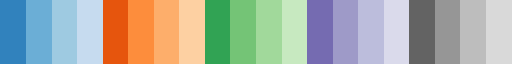

In [101]:
sns.color_palette('tab20c', as_cmap=True)

In [102]:
cmap = sns.color_palette('tab20c', as_cmap=True)
color_map_ = {
    # f'{transformer_name} [692K]': cmap(5), # lighter red
    f'{our_model_name} [783K]': cmap(2),
    'Abstractor [816K]': cmap(9),
    # f'{transformer_name} [871K]': cmap(6), # red
    f'{our_model_name} [1.09M]': cmap(1),
    # f'{transformer_name} [1.3M]': cmap(5),
    f'{our_model_name} [1.43M]': cmap(0),
    'Abstractor [1.54M]': cmap(8),
    # f'{transformer_name} [1.7M]': cmap(4),
    # f'{our_model_name} [832K]': cmap(2),
    # f'{our_model_name} [1.11M]': cmap(1),
    # f'{our_model_name} [1.46M]': cmap(0),
    # 'Transformer': cmap(6), # red
    # 'Transformer+': cmap(4),
    }

model_selection = list(color_map_.keys())

model_filter = figure_data['Model'].isin(model_selection)

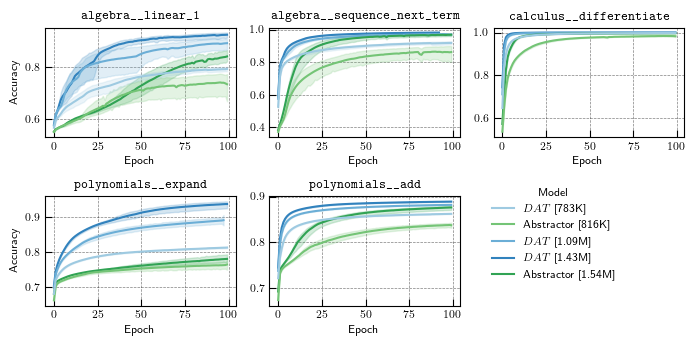

In [103]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter & model_filter]
    ax_data['Model'] = ax_data['Model'].astype('str')

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Training)', hue='Model', legend=False, palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
fig.legend(handles=[Line2D([0], [0], color=c, linestyle='-', label=l) for l, c in color_map_.items()],
    loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.75, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_abstractor_comparison_trainacc.pdf')

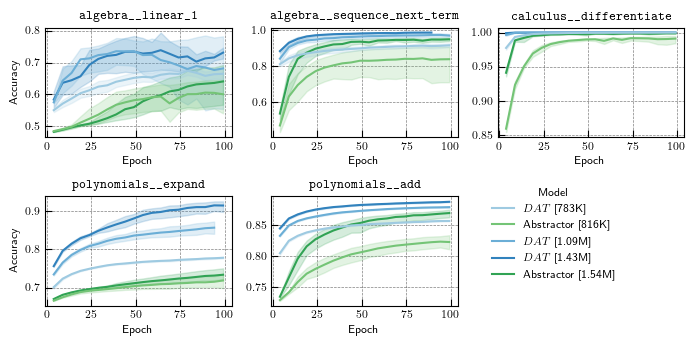

In [104]:
tasks = figure_data.Task.unique()

fig = plt.figure(figsize=(7,3.5))

axes = []
for i, task in enumerate(tasks):
    task_filter = figure_data.Task == task
    ax_data = figure_data.copy()[task_filter & model_filter]
    ax_data['Model'] = ax_data['Model'].astype('str')

    ax = fig.add_subplot(2, 3, i+1)
    sns.lineplot(ax_data, ax=ax, x='Epoch', y='Accuracy (Interpolation)', hue='Model', legend=False, palette=color_map_,
        # estimator='mean', errorbar=('se', 1.96))
        estimator='mean', errorbar=('ci', 95))
    ax.set_title(task)
    if (i % 3) != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Accuracy')

# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
fig.legend(handles=[Line2D([0], [0], color=c, linestyle='-', label=l) for l, c in color_map_.items()],
    loc=(0.7, 0.175), fontsize='medium', title='Model', frameon=False)
# fig.legend(handles=ax.get_lines(), labels=models.values(),  loc=(0.75, 0.15), fontsize='medium', title='Model')
fig.set_tight_layout(True)
fig.savefig(f'{save_dir}/math/math_training_curves_abstractor_comparison_interpolation.pdf')

In [105]:
abstractor_comparison_table = figure_data[figure_data.Epoch == figure_data.Epoch.max()][['Task', 'Model', 'Accuracy (Interpolation)']].dropna()
abstractor_comparison_table['Model'] = pd.Categorical(abstractor_comparison_table['Model'], model_selection, ordered=True)
# abstractor_comparison_table.groupby(['Task', 'Model']).aggregate(['mean', 'sem'])
abstractor_comparison_table = abstractor_comparison_table.groupby(['Task', 'Model']).aggregate('mean')
abstractor_comparison_table = abstractor_comparison_table * 100 # convert to percentage
abstractor_comparison_table

Accuracy (Interpolation)
Task                                       Model                                       
$\texttt{algebra\_\_linear\_1}$            $DAT$ [783K]                       66.475418
                                           Abstractor [816K]                  60.043359
                                           $DAT$ [1.09M]                      68.145008
                                           $DAT$ [1.43M]                      73.108178
                                           Abstractor [1.54M]                 64.069264
$\texttt{algebra\_\_sequence\_next\_term}$ $DAT$ [783K]                       91.618028
                                           Abstractor [816K]                  83.940347
                                           $DAT$ [1.09M]                      97.019757
                                           $DAT$ [1.43M]                            NaN
                                           Abstractor [1.54M]                 94.931567
$\texttt{calculus\_\_differentiate}$       $DAT$ [783K]                       99.986725
                                           Abstractor [816K]                  99.111001
                                           $DAT$ [1.09M]                      99.998611
                                           $DAT$ [1.43M]                      99.998659
                                           Abstractor [1.54M]                 99.880682
$\texttt{polynomials\_\_add}$              $DAT$ [783K]                       85.613560
                                           Abstractor [816K]                  82.238133
                                           $DAT$ [1.09M]                      87.826381
                                           $DAT$ [1.43M]                      88.683220
                                           Abstractor [1.54M]                 86.877863
$\texttt{polynomials\_\_expand}$           $DAT$ [783K]                       77.784697
                                           Abstractor [816K]                  71.861799
                                           $DAT$ [1.09M]                            NaN
                                           $DAT$ [1.43M]                      91.403105
                                           Abstractor [1.54M]                 73.362274

In [ ]:
# # save to latex
# confirm = input('confirm save to latex? (y/n)')
# if confirm == 'y':
#     abstractor_comparison_table.to_latex(f'{save_dir}/math/abstractor_comparison_table.tex',
#         multirow=True, escape=False, na_rep='--', float_format='%.1f\\%%', column_format='l|l|cc')
#     print('saved to latex')

saved to latex


C:\Users\awnya\AppData\Local\Temp\ipykernel_4848\3775897028.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  abstractor_comparison_table.to_latex(f'{save_dir}/math/comparison_table.tex',


## Language Modeling: Fineweb

In [253]:
figure_data = pd.read_csv('figure_data/fineweb/run_histories.csv')
figure_data.head()

C:\Users\awnya\AppData\Local\Temp\ipykernel_8528\188304530.py:1: DtypeWarning: Columns (500,502,503) have mixed types. Specify dtype option on import or set low_memory=False.
  figure_data = pd.read_csv('figure_data/fineweb/run_histories.csv')


,grad_norms/blocks.23.ff_block.linear1.weight,grad_norms/blocks.21.norm2.bias,grad_norms/blocks.20.norm1.weight,grad_norms/blocks.4.dual_attn.self_attention.wk.weight,grad_norms/blocks.14.dual_attn.self_attention.wv.weight,grad_norms/blocks.17.ff_block.linear1.bias,grad_norms/blocks.16.dual_attn.self_attention.wk.weight,grad_norms/blocks.16.dual_attn.relational_attention.wq_attn.weight,grad_norms/blocks.4.dual_attn.relational_attention.wk_attn.weight,grad_norms/blocks.17.dual_attn.self_attention.wv.weight,...,grad_norms/symbol_retrievers.8.q_proj.weight,grad_norms/symbol_retrievers.15.q_proj.bias,grad_norms/symbol_retrievers.23.q_proj.weight,grad_norms/symbol_retrievers.22.q_proj.weight,grad_norms/symbol_retrievers.4.template_features,grad_norms/symbol_retrievers.20.q_proj.weight,grad_norms/symbol_retrievers.18.template_features,grad_norms/symbol_retriever.q_proj.weight,grad_norms/symbol_retriever.q_proj.bias,grad_norms/symbol_retriever.template_features
0,0.016342,0.000575,0.000398,0.001477,0.012219,0.00032,0.002339,0.002593,0.003096,0.010029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [254]:
# NOTE: resumption of DAT-sa16-ra16-nr128-ns2048-sh16-nkvh8-1.27B_2024_07_31_08_52_58 is ongoing TODO: add when completed
name_map = {
    # 1.3B Scale
    'T-sa32-1.3B_2024_07_11_19_05_56': 'Transformer - 1.31B',
    'T-sa32-1.3B_2024_07_11_19_05_56_resumed_2024_07_26_18_41_46': 'Transformer - 1.31B',
    # 'DAT-sa16-ra16-nr64-ns512-sh16-nkvh8-1.27B_2024_07_24_09_41_58': f'{our_model_name} - 1.27B',
    'DAT-sa16-ra16-nr128-ns2048-sh16-nkvh8-1.27B_2024_07_31_08_52_58': f'{our_model_name} - 1.27B',
    'DAT-sa16-ra16-nr128-ns2048-sh16-nkvh8-1.27B_2024_07_31_08_52_58_resumed_2024_08_19_15_26_57': f'{our_model_name} - 1.27B',

    # 'DAT-sa16-ra16-nr64-ns2048-sh8-nkvh8-1.27B_2024_07_28_00_48_29': f'{our_model_name} - 1.27B',
    # 'DAT-sa16-ra16-nr64-ns2048-sh8-1.37B_2024_07_22_18_31_43': f'{our_model_name} - 1.37B',

    # 750M scale
    'T-sa24-757M_2024_08_22_19_01_41': 'Transformer - 757M',
    'DAT-sa12-ra12-nr64-ns1024-sh8-nkvh6-734M_2024_08_21_07_48_32': f'{our_model_name} - 734M',
    'DAT-sa12-ra12-nr64-ns1024-sh8-nkvh6-734M_2024_08_21_07_48_32_resumed_2024_08_23_16_14_12': f'{our_model_name} - 734M',

    # 350M scale
    'T-350M_2024_07_09_17_25_58': 'Transformer - 353M', # TODO check exact param count
    # 'DAT-sa8-ra8-ns1024-sh8-nkvh4-343M_2024_07_19_13_50_14': f'{our_model_name} - 343M',
    # 'DAT-sa8-ra8-ns1024-sh8-nkvh4-343M_2024_07_19_13_50_14_resumed_2024_07_26_18_49_04': f'{our_model_name} - 343M',
    'DAT-sa8-ra8-nr64-ns1024-sh8-nkvh4-343M_2024_07_30_13_58_00': f'{our_model_name} - 343M',
    'DAT-sa8-ra8-nr64-ns1024-sh8-nkvh4-343M_2024_07_30_13_58_00_resumed_2024_08_14_19_34_08': f'{our_model_name} - 343M',
    # 'DAT-ra8sa8nr32-ns1024sh8-368M_2024_07_15_18_38_39': f'{our_model_name} - 368M', # TODO: decide precisely which models want here
}

In [255]:
cmap = plt.cm.tab20

color_map_ = {
    'Transformer - 1.31B': cmap(6), # red
    f'{our_model_name} - 1.27B': cmap(0), # blue
    # f'{our_model_name} - 1.37B': cmap(8), # purple

    'Transformer - 757M': cmap(6), # lighter red
    f'{our_model_name} - 734M': cmap(0),

    'Transformer - 353M': cmap(6), # red
    f'{our_model_name} - 343M': cmap(0), # blue
    # f'{our_model_name} - 368M': cmap(8), # purple
    }

# models = color_map_.keys()

In [256]:
figure_data = figure_data[figure_data.name.isin(name_map.keys())]
figure_data = figure_data[['name', 'loss/val', 'tokens']].dropna()

figure_data = figure_data.rename(columns={
    # 'symbol_type': 'Symbol Type', 'symmetric_rels': 'Symmetric RA', 
    'loss/val': 'Validation Loss', 'tokens': 'Tokens'})


figure_data['Model'] = pd.Categorical(figure_data['name'].map(name_map), list(set(name_map.values())), ordered=True)

figure_data['Perplexity'] = figure_data['Validation Loss'].apply(np.exp)

# figure_data = figure_data[['Model', 'Tokens', 'Perplexity']].dropna()

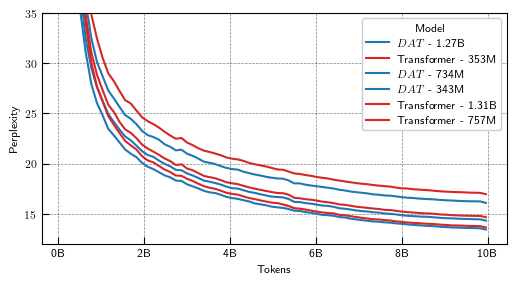

In [12]:
# fig1_models = ['Transformer - 35XM', f'{our_model_name} - 343M', f'{our_model_name} - 368M']
# fig1_data = figure_data[figure_data.Model.isin(fig1_models)]
# fig1_data['Model'] = pd.Categorical(fig1_data['Model'], fig1_models, ordered=True)

fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(figure_data, hue='Model', x='Tokens', y='Perplexity', palette=color_map_)
ax.set_ylim([12, 35]);
ax.set_xticks([x * 10**10 for x in (0, 0.2, 0.4, 0.6, 0.8, 1.0)], [f'{x}B' for x in (0, 2, 4, 6, 8, 10)]);

C:\Users\awnya\AppData\Local\Temp\ipykernel_38644\4100030863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fig1_data['Model'] = pd.Categorical(fig1_data['Model'], fig1_models, ordered=True)


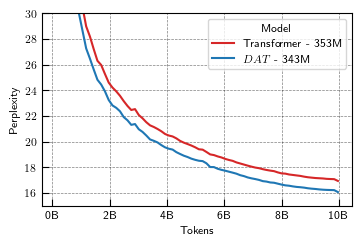

In [13]:
fig1_models = ['Transformer - 353M', f'{our_model_name} - 343M'] #, f'{our_model_name} - 368M']
fig1_data = figure_data[figure_data.Model.isin(fig1_models)]
fig1_data['Model'] = pd.Categorical(fig1_data['Model'], fig1_models, ordered=True)

fig, ax = plt.subplots(figsize=(4, 2.5))
sns.lineplot(fig1_data, hue='Model', x='Tokens', y='Perplexity', palette=color_map_)
# NOTE: missing points; need to fetch from W&B again, perhaps with scan (TODO)
ax.set_ylim([15, 30]);
ax.set_xticks([x * 10**10 for x in (0, 0.2, 0.4, 0.6, 0.8, 1.0)], [f'{x}B' for x in (0, 2, 4, 6, 8, 10)]);
sns.move_legend(ax, loc='upper right', frameon=True, fancybox=True, framealpha=0.8)
fig.savefig(f'{save_dir}/fineweb/350M_scale_lm.pdf', bbox_inches='tight')

C:\Users\awnya\AppData\Local\Temp\ipykernel_38644\1070767284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fig1_data['Model'] = pd.Categorical(fig1_data['Model'], fig1_models, ordered=True)


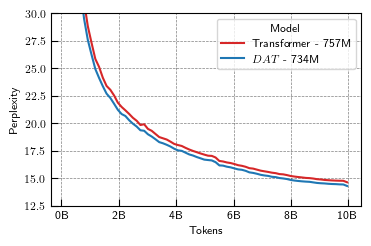

In [17]:
fig1_models = ['Transformer - 757M', f'{our_model_name} - 734M']
fig1_data = figure_data[figure_data.Model.isin(fig1_models)]
fig1_data['Model'] = pd.Categorical(fig1_data['Model'], fig1_models, ordered=True)

fig, ax = plt.subplots(figsize=(4, 2.5))
sns.lineplot(fig1_data, hue='Model', x='Tokens', y='Perplexity', palette=color_map_)
# NOTE: missing points; need to fetch from W&B again, perhaps with scan (TODO)
ax.set_ylim([12.5, 30]);
ax.set_xticks([x * 10**10 for x in (0, 0.2, 0.4, 0.6, 0.8, 1.0)], [f'{x}B' for x in (0, 2, 4, 6, 8, 10)]);
sns.move_legend(ax, loc='upper right', frameon=True, fancybox=True, framealpha=0.8)
fig.savefig(f'{save_dir}/fineweb/750M_scale_lm.pdf', bbox_inches='tight')

C:\Users\awnya\AppData\Local\Temp\ipykernel_38644\2518794497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fig2_data['Model'] = pd.Categorical(fig2_data['Model'], fig2_models, ordered=True)


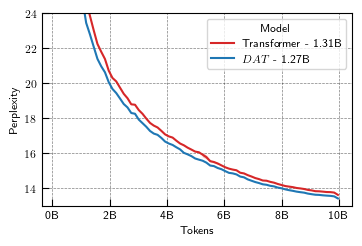

In [18]:
fig2_models = ['Transformer - 1.31B', f'{our_model_name} - 1.27B'] #, f'{our_model_name} - 1.37B']
fig2_data = figure_data[figure_data.Model.isin(fig2_models)]
fig2_data['Model'] = pd.Categorical(fig2_data['Model'], fig2_models, ordered=True)

fig, ax = plt.subplots(figsize=(4, 2.5))
sns.lineplot(fig2_data, hue='Model', x='Tokens', y='Perplexity', palette=color_map_)
# NOTE: missing points; need to fetch from W&B again, perhaps with scan (TODO)
ax.set_ylim([13, 24]);
ax.set_xticks([x * 10**10 for x in (0, 0.2, 0.4, 0.6, 0.8, 1.0)], [f'{x}B' for x in (0, 2, 4, 6, 8, 10)]);
sns.move_legend(ax, loc='upper right', frameon=True, fancybox=True, framealpha=0.8)
fig.savefig(f'{save_dir}/fineweb/1_3B_scale_lm.pdf', bbox_inches='tight')

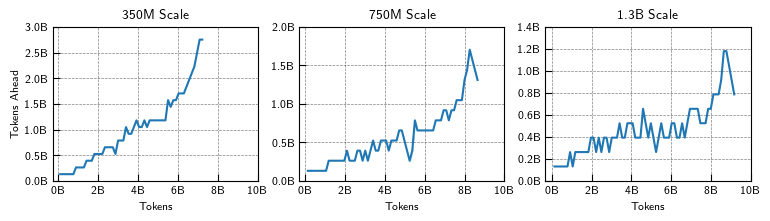

In [75]:
# calculate the number of tokens one model is ahead of the other (measure of sample efficiency)

# let Tok_{Model}(p) be the number of tokens needed to reach at perplexity p for a model Model
# let Perp_{Model}(t) be the perplexity at token t for a model Model
# We plot Tok_{Transformer}(Perp_{DAT}(t)) - t, varying the number of tokens t between 0 and 10B
# This gives the number of tokens DAT is ahead of the Transformer.
# In other words, how many tokens fewer the DAT model needs to train to reach the same perplexity as the Transformer model.

def get_first_tokens_below_perp(line, perp):
    return min([row.Tokens for _, row in line.iterrows() if row.Perplexity < perp], default=np.nan)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 2))

def plot_tokens_ahead(t_line, dat_line, ax):
    toks = dat_line.Tokens
    toks_ahead = [get_first_tokens_below_perp(t_line, row.Perplexity) - row['Tokens']  for _, row in dat_line.iterrows()]
    sns.lineplot(x=toks, y=toks_ahead, ax=ax)
    ax.set_xticks([x * 10**10 for x in (0, 0.2, 0.4, 0.6, 0.8, 1.0)], [f'{x}B' for x in (0, 2, 4, 6, 8, 10)]);
    ax.set_yticks(ax.get_yticks(), [f'{x/1e9:.1f}B' for x in ax.get_yticks()]);
    ax.set_xlabel('Tokens');
    ax.set_ylabel('Tokens Ahead');


ms = ['Transformer - 353M', f'{our_model_name} - 343M']
fig_data = figure_data.copy()
t_line = fig_data[fig_data.Model == ms[0]].sort_values('Tokens')
dat_line = fig_data[fig_data.Model == ms[1]].sort_values('Tokens')
plot_tokens_ahead(t_line, dat_line, ax1)
ax1.set_title('350M Scale');

ms = ['Transformer - 757M', f'{our_model_name} - 734M']
fig_data = figure_data.copy()
t_line = fig_data[fig_data.Model == ms[0]].sort_values('Tokens')
dat_line = fig_data[fig_data.Model == ms[1]].sort_values('Tokens')
plot_tokens_ahead(t_line, dat_line, ax2)
ax2.set_ylabel('')
ax2.set_title('750M Scale');

ms = ['Transformer - 1.31B', f'{our_model_name} - 1.27B']
fig_data = figure_data.copy()
t_line = fig_data[fig_data.Model == ms[0]].sort_values('Tokens')
dat_line = fig_data[fig_data.Model == ms[1]].sort_values('Tokens')
plot_tokens_ahead(t_line, dat_line, ax3)
ax3.set_ylabel('')
ax3.set_title('1.3B Scale');
fig.savefig(f'{save_dir}/fineweb/tokens_ahead.pdf', bbox_inches='tight')

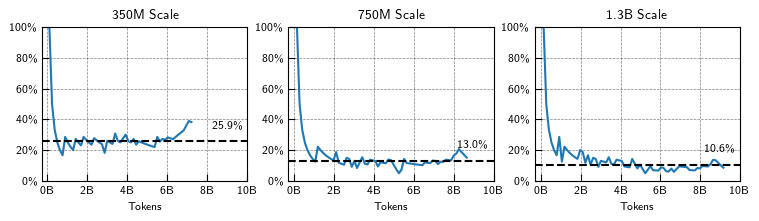

In [76]:
# Tokens Ahead as Percentage Of Current Number of Tokens
# Percent of Data Less Needed to Achieve Same Perplexity

# calculate the number of tokens one model is ahead of the other (measure of sample efficiency)

# let Tok_{Model}(p) be the number of tokens needed to reach at perplexity p for a model Model
# let Perp_{Model}(t) be the perplexity at token t for a model Model
# We plot Tok_{Transformer}(Perp_{DAT}(t)) - t, varying the number of tokens t between 0 and 10B
# This gives the number of tokens DAT is ahead of the Transformer.
# In other words, how many tokens fewer the DAT model needs to train to reach the same perplexity as the Transformer model.

# Lead of about 
import matplotlib.ticker as mtick

# calculate the number of tokens one model is ahead of the other (measure of sample efficiency)
def get_first_tokens_below_perp(line, perp):
    return min([row.Tokens for _, row in line.iterrows() if row.Perplexity < perp], default=np.nan)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 2))

def plot_tokens_ahead_percent(t_line, dat_line, ax):
    toks = dat_line.Tokens
    toks_ahead_percent = [(get_first_tokens_below_perp(t_line, row.Perplexity) - row['Tokens'])/row['Tokens']  for _, row in dat_line.iterrows()]
    sns.lineplot(x=toks, y=toks_ahead_percent, ax=ax)
    median = np.median([x for x in toks_ahead_percent if not np.isnan(x)])
    # median = np.mean([x for x in toks_ahead_percent if not np.isnan(x)])
    ax.axhline(median, color='black', linestyle='--')
    ax.text(9e9, median+0.1, r"{:1.1f}\%".format(median*100.0), ha='center', va='center', color='black')

    ax.set_xticks([x * 10**10 for x in (0, 0.2, 0.4, 0.6, 0.8, 1.0)], [f'{x}B' for x in (0, 2, 4, 6, 8, 10)]);
    # ax.set_yticks(ax.get_yticks(), [f'{x/1e9:.1f}B' for x in ax.get_yticks()]);
    ax.set_ylim([0,1]);
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.set_xlabel('Tokens');
    ax.set_ylabel('% Tokens Ahead');


ms = ['Transformer - 353M', f'{our_model_name} - 343M']
fig_data = figure_data.copy()
t_line = fig_data[fig_data.Model == ms[0]].sort_values('Tokens')
dat_line = fig_data[fig_data.Model == ms[1]].sort_values('Tokens')
plot_tokens_ahead_percent(t_line, dat_line, ax1)
ax1.set_title('350M Scale');

ms = ['Transformer - 757M', f'{our_model_name} - 734M']
fig_data = figure_data.copy()
t_line = fig_data[fig_data.Model == ms[0]].sort_values('Tokens')
dat_line = fig_data[fig_data.Model == ms[1]].sort_values('Tokens')
plot_tokens_ahead_percent(t_line, dat_line, ax2)
ax2.set_ylabel('')
ax2.set_title('750M Scale');

ms = ['Transformer - 1.31B', f'{our_model_name} - 1.27B']
fig_data = figure_data.copy()
t_line = fig_data[fig_data.Model == ms[0]].sort_values('Tokens')
dat_line = fig_data[fig_data.Model == ms[1]].sort_values('Tokens')
plot_tokens_ahead_percent(t_line, dat_line, ax3)
ax3.set_ylabel('')
ax3.set_title('1.3B Scale');
fig.savefig(f'{save_dir}/fineweb/tokens_ahead_percent.pdf', bbox_inches='tight')

Paramater vs Data Scaling

In [328]:
def get_first_tokens_below_perp(line, perp):
    return min([row.Tokens for _, row in line.iterrows() if row.Perplexity < perp], default=np.nan)

df = pd.DataFrame()

perplexities = np.linspace(15, 30, 6)

for model in figure_data.Model.unique():
    line = figure_data[figure_data.Model == model].sort_values('Tokens')
    tokens = [get_first_tokens_below_perp(line, p) for p in perplexities]
    df_ = pd.DataFrame({'Perplexity': perplexities, 'Tokens': tokens, #'Model': [model]*len(perplexities), 
        'Param Count': [parse_param_count(model)] * len(perplexities), 'Model': [model.split('-')[0]]*len(perplexities)})
    df = pd.concat([df, df_])
df = df.reset_index(drop=True)

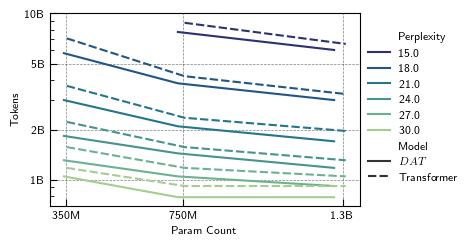

In [343]:
fig, ax = plt.subplots(figsize=(4, 2.5))
sns.lineplot(data=df, x='Param Count', y='Tokens', hue='Perplexity', style='Model', ax=ax,
    palette=sns.color_palette("crest_r", as_cmap=True),
    # palette=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
    # palette=sns.color_palette("dark:salmon_r", as_cmap=True),
    )
ax.set_yscale('log');
ax.set_xticks([350e6, 750e6, 1.3e9], ['350M', '750M', '1.3B']);
ax.set_yticks([1e9, 2e9, 5e9, 10e9], ['1B', '2B', '5B', '10B']);
sns.move_legend(ax, loc='upper right', frameon=False, fancybox=False, bbox_to_anchor=(1.35,0.95))
fig.savefig(f'{save_dir}/fineweb/tokens_vs_param_count.pdf', bbox_inches='tight')

C:\Users\awnya\AppData\Local\Temp\ipykernel_38644\1612352718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fig1_data['Model'] = pd.Categorical(fig1_data['Model'], fig1_models, ordered=True)
C:\Users\awnya\AppData\Local\Temp\ipykernel_38644\1612352718.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fig2_data['Model'] = pd.Categorical(fig2_data['Model'], fig2_models, ordered=True)
C:\Users\awnya\AppData\Local\Temp\ipykernel_38644\1612352718.py:35: SettingWithCopyWarning: 
A value is trying to be se

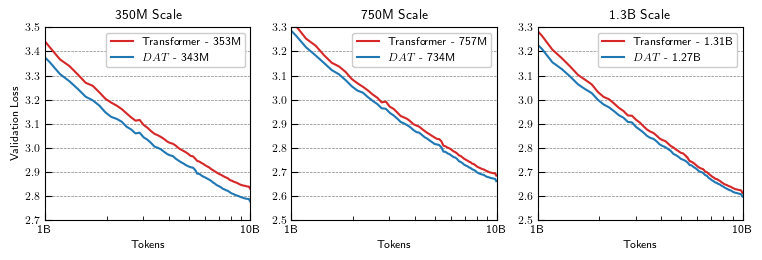

In [74]:
# Val Loss - Log Tokens

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 2.5))
fig1_models = ['Transformer - 353M', f'{our_model_name} - 343M'] #, f'{our_model_name} - 368M']
fig1_data = figure_data[figure_data.Model.isin(fig1_models)]
fig1_data['Model'] = pd.Categorical(fig1_data['Model'], fig1_models, ordered=True)

sns.lineplot(fig1_data, hue='Model', x='Tokens', y='Validation Loss', palette=color_map_, ax=ax1)
# NOTE: missing points; need to fetch from W&B again, perhaps with scan (TODO)
ax1.set_ylim([2.7, 3.5]);
ax1.set_xlim([1e9, 10e9])
ax1.set_xscale('log')
ax1.set_xticks([1e9, 10e9], ['1B', '10B']);
ax1.set_title('350M Scale');

# Val Loss - Log Tokens

fig2_models = ['Transformer - 757M', f'{our_model_name} - 734M']
fig2_data = figure_data[figure_data.Model.isin(fig2_models)]
fig2_data['Model'] = pd.Categorical(fig2_data['Model'], fig2_models, ordered=True)

sns.lineplot(fig2_data, hue='Model', x='Tokens', y='Validation Loss', palette=color_map_, ax=ax2)
ax2.set_ylim([2.5, 3.3]);
ax2.set_xlim([1e9, 10e9])
ax2.set_xscale('log')
ax2.set_xticks([1e9, 10e9], ['1B', '10B']);
ax2.set_title('750M Scale');
ax2.set_ylabel('');


# Val Loss - Log Tokens

fig3_models = ['Transformer - 1.31B', f'{our_model_name} - 1.27B'] #, f'{our_model_name} - 1.37B']
fig3_data = figure_data[figure_data.Model.isin(fig3_models)]
fig3_data['Model'] = pd.Categorical(fig3_data['Model'], fig3_models, ordered=True)

sns.lineplot(fig3_data, hue='Model', x='Tokens', y='Validation Loss', palette=color_map_, ax=ax3)
ax3.set_ylim([2.5, 3.3]);
ax3.set_xlim([1e9, 10e9])
ax3.set_xscale('log')
ax3.set_xticks([1e9, 10e9], ['1B', '10B']);
ax3.set_title('1.3B Scale');
ax3.set_ylabel('');

for ax in [ax1, ax2, ax3]:
    # sns.move_legend(ax, loc='upper right', frameon=True, fancybox=True, framealpha=0.8)
    sns.move_legend(ax, loc='upper right', frameon=True, title='')

fig.savefig(f'{save_dir}/fineweb/valloss_logtok.pdf', bbox_inches='tight')

## Language Modeling: Tiny Stories

In [ ]:
figure_data = pd.read_csv('figure_data/tiny_stories/run_histories.csv')
figure_data.head()

,val/perplexity,mfu,tokens,Generated Samples,lr,val/loss,train/loss,_timestamp,_step,train/perplexity,...,n_layers,wandb_log,weight_decay,vocab_source,out_dir,pos_enc_type,beta1,sym_attn_n_symbols,group,name
0,39238.144531,-100.000000,0.000000e+00,NaN,0.001,10.577385,10.578004,1.716068e+09,0,39261.359375,...,6,True,0.1,llama2,out/sa=4; rca=4; d=128; L=6; rca_type=disentan...,RoPE,0.9,512.0,NaN,sa=4; rca=4; d=128; L=6; rca_type=disentangled...
1,5.612392,3.820743,2.621440e+08,NaN,0.001,1.724343,1.727050,1.716069e+09,2000,5.626907,...,6,True,0.1,llama2,out/sa=4; rca=4; d=128; L=6; rca_type=disentan...,RoPE,0.9,512.0,NaN,sa=4; rca=4; d=128; L=6; rca_type=disentangled...
2,4.960096,3.820697,5.242880e+08,NaN,0.001,1.600834,1.604139,1.716071e+09,4000,4.975849,...,6,True,0.1,llama2,out/sa=4; rca=4; d=128; L=6; rca_type=disentan...,RoPE,0.9,512.0,NaN,sa=4; rca=4; d=128; L=6; rca_type=disentangled...
3,4.704290,3.820555,7.864320e+08,NaN,0.001,1.547904,1.550540,1.716072e+09,6000,4.716177,...,6,True,0.1,llama2,out/sa=4; rca=4; d=128; L=6; rca_type=disentan...,RoPE,0.9,512.0,NaN,sa=4; rca=4; d=128; L=6; rca_type=disentangled...
4,4.540239,3.820479,1.048576e+09,NaN,0.001,1.512442,1.515324,1.716074e+09,8000,4.552852,...,6,True,0.1,llama2,out/sa=4; rca=4; d=128; L=6; rca_type=disentan...,RoPE,0.9,512.0,NaN,sa=4; rca=4; d=128; L=6; rca_type=disentangled...


In [ ]:
# bar plot figure
color_map_ = {
    'Transformer ($n_h^{sa}=8, n_h^{ra}=0$)': cmap(6), # red
    f'{our_model_name} ($n_h^{{sa}}=6, n_h^{{ra}}=2$)': cmap(8), # purple
    f'{our_model_name} ($n_h^{{sa}}=4, n_h^{{ra}}=4$)': cmap(0), # blue
    # 'Transformer+': cmap(4),
    }

models = color_map_.keys()

In [ ]:
def get_model_name(row):
    if row.rca == 0:
        return f'Transformer ($n_h^{{sa}}={row.sa}, n_h^{{ra}}={row.rca}$)'
    else:
        # return f"AbstractTransformer [{row['Symbol Type']}, symm={row['Symmetric RA']}] ($n_h^{{sa}} = {row.sa}, n_h^{{ra}}={row.rca}$)"
        return f"{our_model_name} ($n_h^{{sa}}={row.sa}, n_h^{{ra}}={row.rca}$)"

In [ ]:
figure_data = figure_data.rename(columns={
    'symbol_type': 'Symbol Type', 'symmetric_rels': 'Symmetric RA', 
    'val/loss': 'Validation Loss', 'val/perplexity': 'Validation Perplexity', 'tokens': 'Tokens'})

figure_data.loc[figure_data['rca']==0, 'Symbol Type'] = 'NA'
figure_data.loc[figure_data['rca']==0, 'Symmetric RA'] = 'NA'

figure_data['Model'] = pd.Categorical(figure_data.apply(get_model_name, axis=1), models, ordered=True)
sym_map = {'sym_attn': 'Symbolic Attention', 'pos_relative': 'Position-Relative Symbols'}
figure_data['Symbol Type'] = pd.Categorical(figure_data['Symbol Type'].map(sym_map), sym_map.values(), ordered=True)

In [ ]:
def filter_data(figure_data, d_models=None, layers=None, filter_first_step=False, filter_transformer=False, symbol_types=None, symmetry=None, rca_types=None):
    filter_ = ~figure_data.index.isna()
    if d_models is not None:
        filter_ = filter_ & (figure_data['d_model'].isin(d_models))
    if layers is not None:
        filter_ = filter_ & (figure_data['n_layers'].isin(layers))
    if filter_transformer:
        filter_ = filter_ & (figure_data['rca'] > 0)
    if filter_first_step:
        filter_ = filter_ & (figure_data['_step'] > 0)
    if symbol_types is not None:
        symbol_types = [sym_map[s] for s in symbol_types]
        filter_ = filter_ & ((figure_data['rca'] == 0) | figure_data['Symbol Type'].isin(symbol_types))
    if symmetry is not None:
        filter_ = filter_ & ((figure_data['rca'] == 0) | figure_data['Symmetric RA'].isin(symmetry))
    if rca_types is not None:
        filter_ = filter_ & ((figure_data['rca'] == 0) | (figure_data['rca_type'].isin(rca_types)))
    filtered_data = figure_data.copy()[filter_]

    if filter_transformer:
        filtered_data['Model'] = filtered_data['Model'].cat.remove_unused_categories()

    return filtered_data

### All Plots & Ablations

============================================ d=64; L=4 =============================================
Symbolic Attention & Asymmetric DisRA


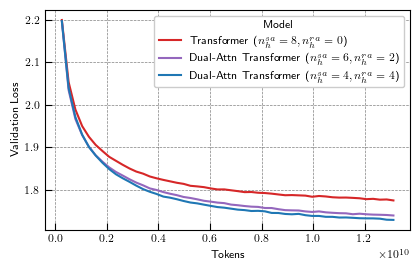

Symbolic Attention & Symmetric DisRA


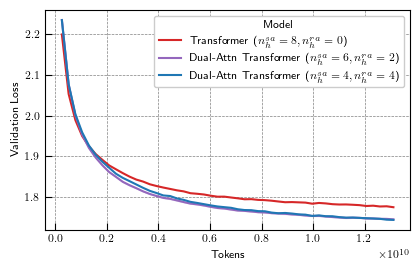

Ablation of Symmetry (Symbolic Attention)


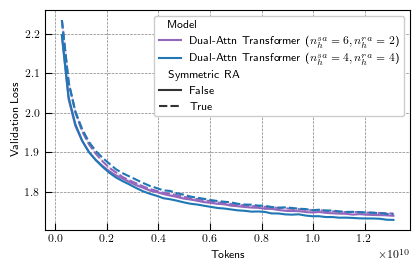

Ablation of Symmetry (Position-Relative Symbols)


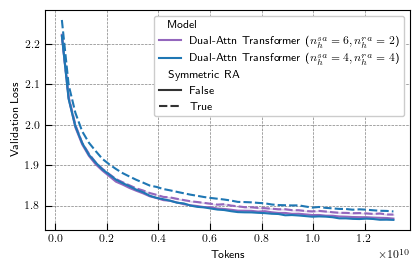

Ablation of Symbol Type (Symmetric DisRA)


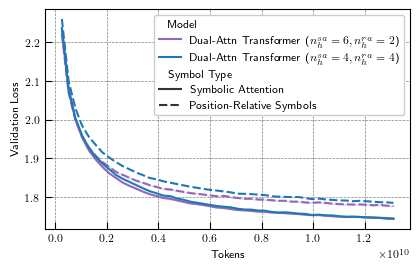

Ablation of Symbol Type (Asymmetric DisRA)


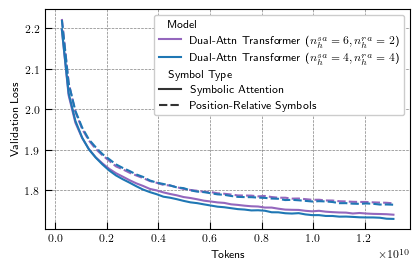

============================================ d=64; L=5 =============================================
Symbolic Attention & Asymmetric DisRA


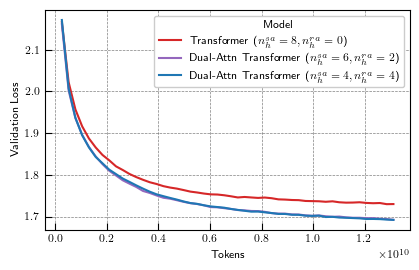

Symbolic Attention & Symmetric DisRA


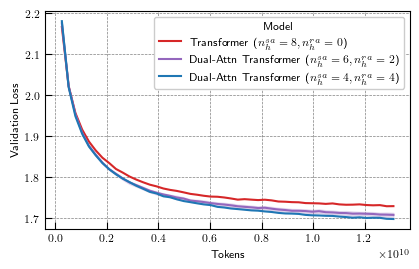

Ablation of Symmetry (Symbolic Attention)


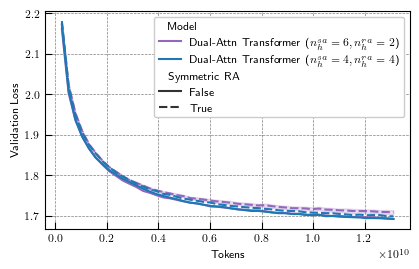

Ablation of Symmetry (Position-Relative Symbols)


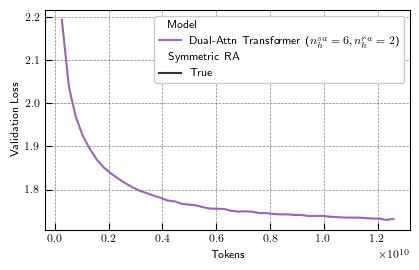

Ablation of Symbol Type (Symmetric DisRA)


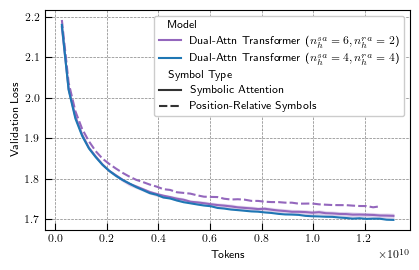

Ablation of Symbol Type (Asymmetric DisRA)


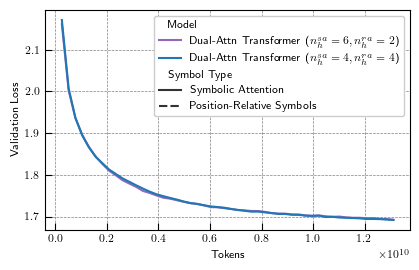

============================================ d=64; L=6 =============================================
Symbolic Attention & Asymmetric DisRA


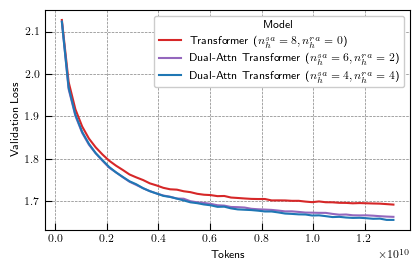

Symbolic Attention & Symmetric DisRA


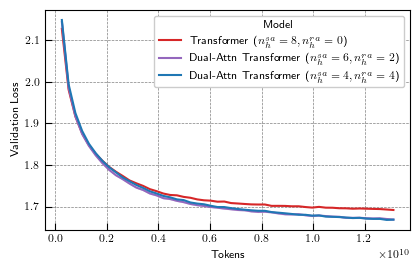

Ablation of Symmetry (Symbolic Attention)


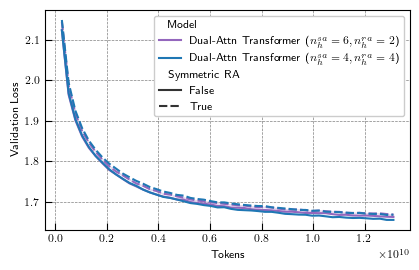

Ablation of Symmetry (Position-Relative Symbols)


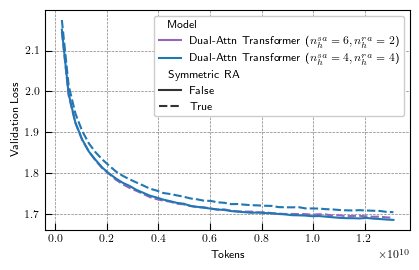

Ablation of Symbol Type (Symmetric DisRA)


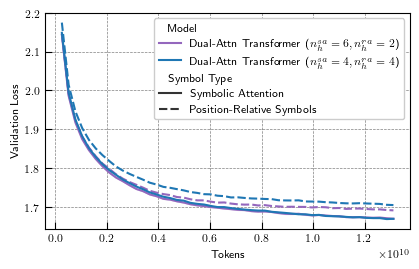

Ablation of Symbol Type (Asymmetric DisRA)


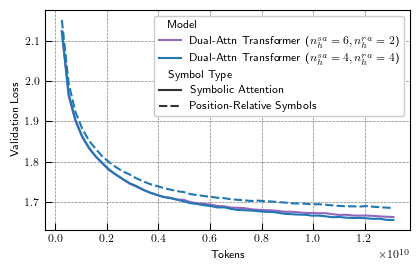

============================================ d=128; L=4 =============================================
Symbolic Attention & Asymmetric DisRA


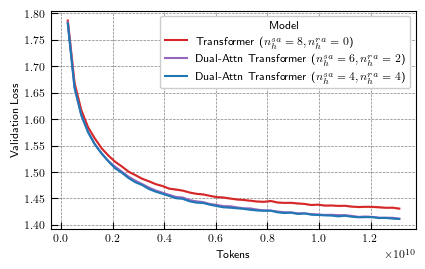

Symbolic Attention & Symmetric DisRA


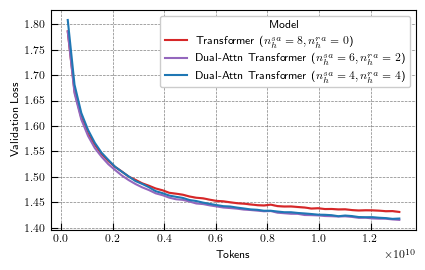

Ablation of Symmetry (Symbolic Attention)


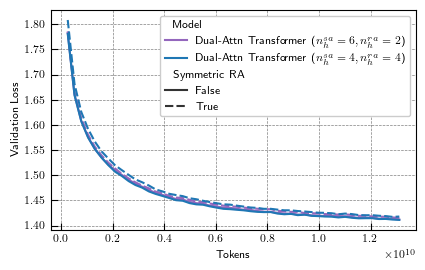

Ablation of Symmetry (Position-Relative Symbols)


C:\Users\awnya\AppData\Local\Temp\ipykernel_10020\2777058707.py:42: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='Symmetric RA', palette=color_map_, ax=ax);


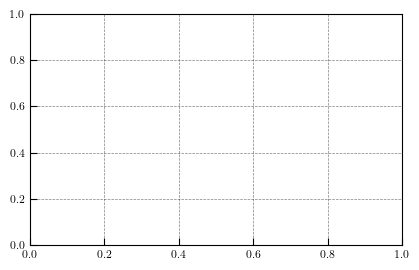

Ablation of Symbol Type (Symmetric DisRA)


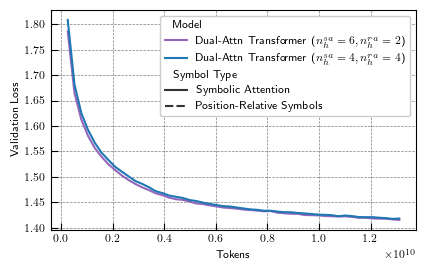

Ablation of Symbol Type (Asymmetric DisRA)


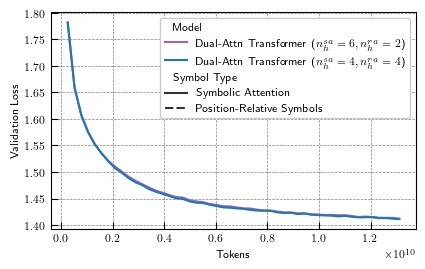

============================================ d=128; L=6 =============================================
Symbolic Attention & Asymmetric DisRA


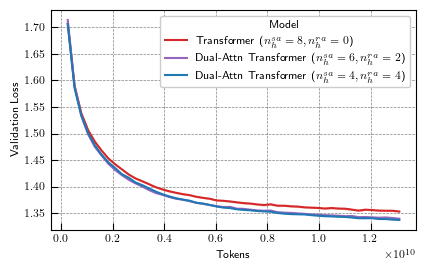

Symbolic Attention & Symmetric DisRA


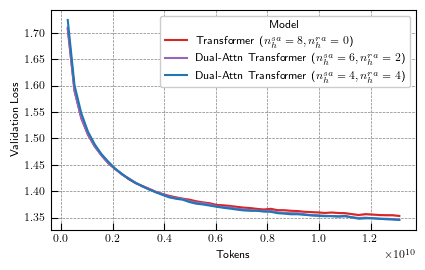

Ablation of Symmetry (Symbolic Attention)


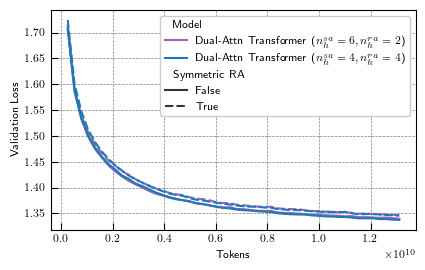

Ablation of Symmetry (Position-Relative Symbols)


C:\Users\awnya\AppData\Local\Temp\ipykernel_10020\2777058707.py:42: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='Symmetric RA', palette=color_map_, ax=ax);


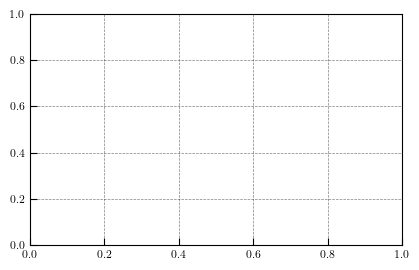

Ablation of Symbol Type (Symmetric DisRA)


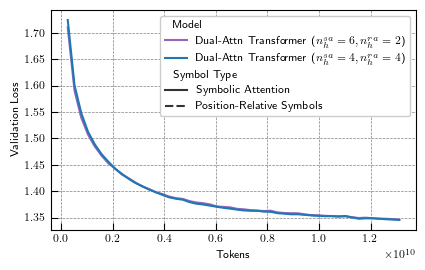

Ablation of Symbol Type (Asymmetric DisRA)


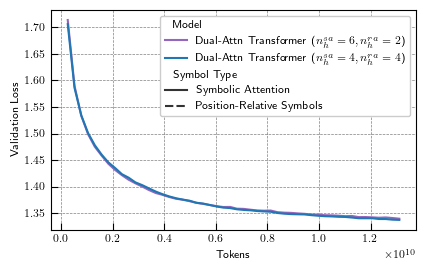

In [9]:
figsize=(4,2.5)
dLs = [(64, 4), (64, 5), (64, 6), (128, 4), (128, 6)]
for d, L in dLs:
    print('='*44 + f' d={d}; L={L} ' + '='*45)
    print('='*100)

    # symbolic attention and asymmetric RA
    print('Symbolic Attention & Asymmetric DisRA')
    fig, ax = plt.subplots(figsize=figsize)
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True,
        symbol_types=('sym_attn',), symmetry=(False,), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', palette=color_map_, ax=ax);
    plt.tight_layout(pad=0)
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_symattn_asymra.pdf')
    plt.show()

    # symbolic attention and symmetric RA
    print('Symbolic Attention & Symmetric DisRA')
    fig, ax = plt.subplots(figsize=figsize)
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True,
        symbol_types=('sym_attn',), symmetry=(True,), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', palette=color_map_, ax=ax);
    plt.tight_layout(pad=0)
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_symattn_symra.pdf')
    plt.show()

    # ablation of symmetry; symbolic attention
    print('Ablation of Symmetry (Symbolic Attention)')
    fig, ax = plt.subplots(figsize=figsize)
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True, filter_transformer=True,
        symbol_types=('sym_attn',), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='Symmetric RA', palette=color_map_, ax=ax);
    plt.tight_layout(pad=0)
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_ablation_symmetry_symmattn.pdf')
    plt.show()

    # ablation of symmetry; position-relative symbols
    print('Ablation of Symmetry (Position-Relative Symbols)')
    fig, ax = plt.subplots(figsize=figsize)
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True, filter_transformer=True,
        symbol_types=('pos_relative',), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='Symmetric RA', palette=color_map_, ax=ax);
    plt.tight_layout(pad=0)
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_ablation_symmetry_posrelsym.pdf')
    plt.show()

    # ablation of symbol type; symmetric rel
    print('Ablation of Symbol Type (Symmetric DisRA)')
    fig, ax = plt.subplots(figsize=figsize)
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True, filter_transformer=True,
        symbol_types=('sym_attn', 'pos_relative'), symmetry=(True, ), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='Symbol Type', palette=color_map_, ax=ax);
    plt.tight_layout(pad=0)
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_ablation_symboltype_symra.pdf')
    plt.show()

    # ablation of symbol type; asymmetric rel
    print('Ablation of Symbol Type (Asymmetric DisRA)')
    fig, ax = plt.subplots(figsize=figsize)
    figure_data_ = filter_data(figure_data, d_models=[d], layers=[L], filter_first_step=True, filter_transformer=True,
        symbol_types=('sym_attn', 'pos_relative'), symmetry=(False, ), rca_types=('disentangled_v2',))
    sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='Symbol Type', palette=color_map_, ax=ax);
    plt.tight_layout(pad=0)
    fig.savefig(f'{save_dir}/tiny_stories/d{d}L{L}_ablation_symboltype_asymra.pdf')
    plt.show()

    print('='*100)

Symbolic Attention & Asymmetric DisRA


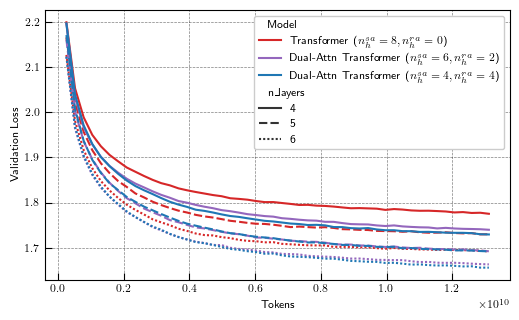

In [10]:
# symbolic attention and asymmetric RA
print('Symbolic Attention & Asymmetric DisRA')
fig, ax = plt.subplots(figsize=(5, 3))
figure_data_ = filter_data(figure_data, d_models=[64], layers=[4, 5, 6], filter_first_step=True,
    symbol_types=('sym_attn',), symmetry=(False,), rca_types=('disentangled_v2',))
sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='n_layers', palette=color_map_, ax=ax);
plt.tight_layout(pad=0)
fig.savefig(f'{save_dir}/tiny_stories/d64L4L5L6_symattn_asymra.pdf')
plt.show()

Symbolic Attention & Asymmetric DisRA


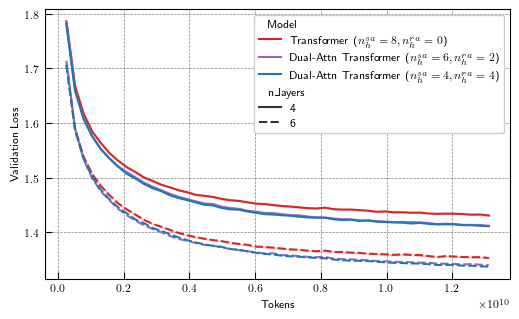

In [11]:
# symbolic attention and asymmetric RA
print('Symbolic Attention & Asymmetric DisRA')
fig, ax = plt.subplots(figsize=(5, 3))
figure_data_ = filter_data(figure_data, d_models=[128], layers=[4,  6], filter_first_step=True,
    symbol_types=('sym_attn',), symmetry=(False,), rca_types=('disentangled_v2',))
sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='n_layers', palette=color_map_, ax=ax);
plt.tight_layout(pad=0)
fig.savefig(f'{save_dir}/tiny_stories/d128L4L6_symattn_asymra.pdf')
plt.show()

# TODO: need missing run with d=128,L=6, sym_attn, asym_ra, n_h^{sa}=4, n_h^{ra}=4

RA Type Ablation


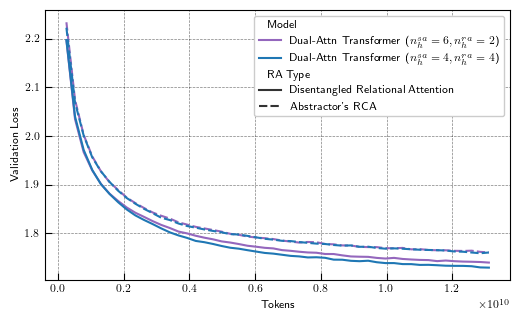

In [12]:
# RCA TYPE ABLATION
print('RA Type Ablation')
fig, ax = plt.subplots(figsize=(5, 3))
figure_data_ = filter_data(figure_data, d_models=[64], layers=[4], filter_first_step=True, filter_transformer=True,
    symbol_types=('sym_attn',), symmetry=(False,), rca_types=('disentangled_v2', 'standard'))
figure_data_.rename(columns={'rca_type': 'RA Type'}, inplace=True)
figure_data_['Model'] = pd.Categorical(figure_data_['Model'], list(models)[1:], ordered=True) # remove transformer
figure_data_['RA Type'] = pd.Categorical(
    figure_data_['RA Type'].map(
        {'disentangled_v2': 'Disentangled  Relational Attention', 'standard': "Abstractor's RCA"}),
        ['Disentangled  Relational Attention', "Abstractor's RCA"], ordered=True)
sns.lineplot(figure_data_, x='Tokens', y='Validation Loss', hue='Model', style='RA Type', palette=color_map_, ax=ax);
plt.tight_layout(pad=0)
fig.savefig(f'{save_dir}/tiny_stories/d64L4_ra_type_ablation_symattn_asymra.pdf')
plt.show()

### Table Summary

In [13]:
figure_data['Symbol Type'] = figure_data['Symbol Type'].astype(str).fillna('NA')
figure_data['Symmetric RA'] = figure_data['Symmetric RA'].astype(str).fillna('NA')
figure_data['Symbol Type'] = figure_data['Symbol Type'].replace('nan', 'NA')

In [14]:
metric_cols = ['Validation Loss', 'Validation Perplexity']
group_cols = ['d_model', 'n_layers', 'sa', 'rca', 'Symbol Type', 'Symmetric RA']

summary = filter_data(figure_data, rca_types=('disentangled_v2',)).groupby(group_cols)[metric_cols].min().reset_index().dropna(subset=metric_cols)

# filter out certain entries
summary = summary[summary.d_model <= 128]

summary.set_index(['d_model', 'n_layers', 'sa', 'rca', 'Symbol Type', 'Symmetric RA'], inplace=True)
summary[metric_cols]= summary[metric_cols].round(3)
summary

Validation Loss  \
d_model n_layers sa rca Symbol Type               Symmetric RA                    
64      4        4  4   Position-Relative Symbols False                   1.764   
                                                  True                    1.785   
                        Symbolic Attention        False                   1.729   
                                                  True                    1.744   
                 6  2   Position-Relative Symbols False                   1.768   
                                                  True                    1.777   
                        Symbolic Attention        False                   1.740   
                                                  True                    1.745   
                 8  0   NA                        NA                      1.775   
        5        4  4   Symbolic Attention        False                   1.692   
                                                  True                    1.698   
                 6  2   Position-Relative Symbols True                    1.730   
                        Symbolic Attention        False                   1.692   
                                                  True                    1.704   
                 8  0   NA                        NA                      1.730   
        6        4  4   Position-Relative Symbols False                   1.685   
                                                  True                    1.704   
                        Symbolic Attention        False                   1.656   
                                                  True                    1.668   
                 6  2   Position-Relative Symbols True                    1.691   
                        Symbolic Attention        False                   1.663   
                                                  True                    1.669   
                 8  0   NA                        NA                      1.692   
128     4        4  4   Symbolic Attention        False                   1.411   
                                                  True                    1.417   
                 6  2   Symbolic Attention        False                   1.412   
                                                  True                    1.415   
                 8  0   NA                        NA                      1.431   
        6        4  4   Symbolic Attention        False                   1.337   
                                                  True                    1.346   
                 6  2   Symbolic Attention        False                   1.340   
                                                  True                    1.346   
                 8  0   NA                        NA                      1.353   

                                                                Validation Perplexity  
d_model n_layers sa rca Symbol Type               Symmetric RA                         
64      4        4  4   Position-Relative Symbols False                         5.840  
                                                  True                          5.963  
                        Symbolic Attention        False                         5.639  
                                                  True                          5.722  
                 6  2   Position-Relative Symbols False                         5.859  
                                                  True                          5.914  
                        Symbolic Attention        False                         5.697  
                                                  True                          5.727  
                 8  0   NA                        NA                            5.903  
        5        4  4   Symbolic Attention        False                         5.431  
                                                  True                          5.467  
              

In [15]:
# write string to file
# with open(f'{save_dir}/tiny_stories/tiny_stories_summary_table.tex', 'w') as f:
#     f.write(summary.to_latex())

## Vision (ImageNet)

In [16]:
figure_data = pd.read_csv('figure_data/imagenet/run_histories.csv')
figure_data.dropna(subset=['train/acc_epoch', 'val/loss'], inplace=True, how='all') # drop step rows and keep epoch rows
figure_data.head()

In [17]:
model_name_map = {
    'sa=16; d=1024; L=24__2024_05_15_16_38_09': 'Transformer ($n_h^{sa}=16, n_h^{ra}=0$)',
    'sa=10; rca=6; d=1024; L=24; rca_type=disentangled_v2; sym_rel=True; symbol_type=pos_relative__2024_05_15_18_13_54': f'{our_model_name} ($n_h^{{sa}}=10, n_h^{{ra}}=6$)'
    }

figure_data['Model'] = pd.Categorical(figure_data['name'].map(model_name_map), model_name_map.values(), ordered=True)

color_map_ = {
    'Transformer ($n_h^{sa}=16, n_h^{ra}=0$)': cmap(6), # red
    f'{our_model_name} ($n_h^{{sa}}=10, n_h^{{ra}}=6$)': cmap(8), # purple
    f'{our_model_name} ($n_h^{{sa}}=10, n_h^{{ra}}=6$)': cmap(0), # blue
    }

In [18]:
df_ = figure_data[['epoch', 'train/acc_epoch', 'Model']].dropna().pivot(index='epoch', columns='Model', values='train/acc_epoch')
trainacc_diff = abs(df_.iloc[:,0] - df_.iloc[:,1])
print(f'train/acc mean difference: {trainacc_diff.mean():.2%}')
print(f'train/acc max difference: {trainacc_diff.max():.2%}')
print(f'train/acc end difference: {abs(max(df_.iloc[:,0]) - max(df_.iloc[:,1])):.2%}')
print()
df_ = figure_data[['epoch', 'val/acc', 'Model']].dropna().pivot(index='epoch', columns='Model', values='val/acc')
valacc_diff = abs(df_.iloc[:,0] - df_.iloc[:,1])
print(f'val/acc mean difference: {valacc_diff.mean():.2%}')
print(f'val/acc max difference: {valacc_diff.max():.2%}')
print(f'val/acc end difference: {abs(max(df_.iloc[:,0]) - max(df_.iloc[:,1])):.2%}')

train/acc mean difference: 5.01%
train/acc max difference: 10.08%
train/acc end difference: 2.89%

val/acc mean difference: 4.39%
val/acc max difference: 9.98%
val/acc end difference: 1.46%


In [23]:
figure_data.rename(columns={'train/acc_epoch': 'Training Accuracy', 'val/acc': 'Validation Accuracy',
    'val/loss': 'Validation Loss', 'train/loss_epoch': 'Training Loss', 'epoch': 'Epoch'}, inplace=True)

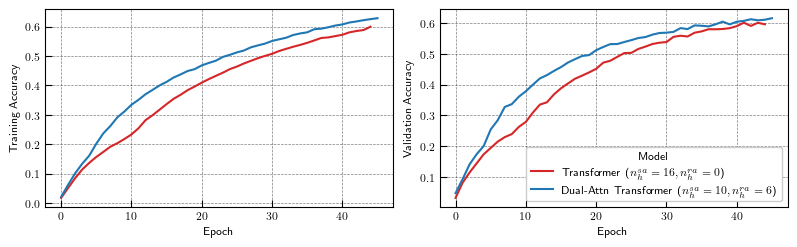

In [37]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 2.5), ncols=2, nrows=1)
sns.lineplot(figure_data, x='Epoch', y='Training Accuracy', hue='Model', palette=color_map_, ax=ax1, legend=False);
sns.lineplot(figure_data, x='Epoch', y='Validation Accuracy', hue='Model', palette=color_map_, ax=ax2);
# plt.subplots_adjust(wspace=0.2)
plt.tight_layout(pad=1)
fig.savefig(f'{save_dir}/imagenet/imagenet_acc_curves.pdf')

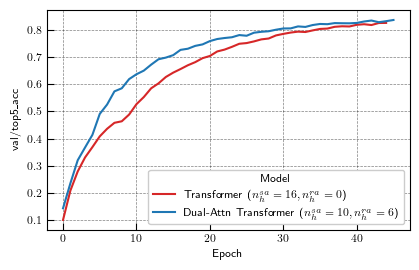

In [25]:
fig, ax = plt.subplots(figsize=(4, 2.5))
sns.lineplot(figure_data, x='Epoch', y='val/top5_acc', hue='Model', palette=color_map_, ax=ax);
plt.tight_layout(pad=0)
fig.savefig(f'{save_dir}/imagenet/imagenet_top5acc_curves.pdf')

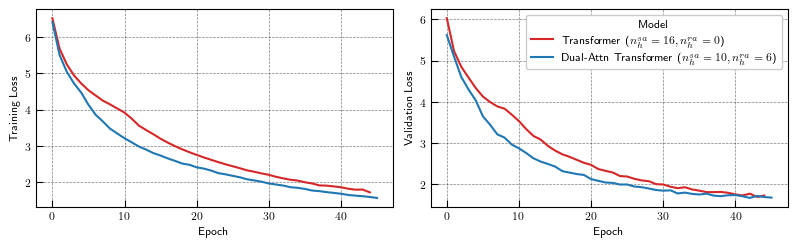

In [38]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 2.5), ncols=2, nrows=1)
sns.lineplot(figure_data, x='Epoch', y='Training Loss', hue='Model', palette=color_map_, ax=ax1, legend=False);
sns.lineplot(figure_data, x='Epoch', y='Validation Loss', hue='Model', palette=color_map_, ax=ax2);
plt.tight_layout(pad=1)
fig.savefig(f'{save_dir}/imagenet/imagenet_loss_curves.pdf')

## Vision (CIFAR)

In [206]:
figure_data = pd.read_csv(f'figure_data/cifar/end_of_training.csv')

our_model_name = r'\textit{ViDAT}'
transformer_name = r'\textit{ViT}'

In [207]:
for dataset in figure_data.dataset.unique():
    print()
    print('='*100)
    pool = 'mean'
    print(dataset.capitalize())
    for autoaugment in figure_data.autoaugment.unique():
        filter_ = (figure_data.dataset == dataset) & (figure_data.pool == pool) & (figure_data.autoaugment == autoaugment)
        data_ = figure_data[filter_]
        if data_.empty:
            continue
        print()
        print(f'{dataset} - pool={pool} - aa={autoaugment}')
        print(data_.groupby('group')['acc/val'].aggregate(['mean', 'std']).round(3).sort_values('mean'))
        print('-'*100)


Cifar100

cifar100 - pool=mean - aa=False
                                                     mean    std
group                                                           
vit_cifar100_rc_cm_mu-pool=mean                     0.688  0.006
vidat_cifar100-sa=6-ra=6-nr=24-symrel=False-sym...  0.696  0.004
vidat_cifar100-sa=6-ra=6-nr=24-symrel=True-symb...  0.697  0.004
vidat_cifar100-sa=6-ra=6-nr=12-symrel=False-sym...  0.700  0.005
vidat_cifar100-sa=6-ra=6-nr=12-symrel=True-symb...  0.701  0.004
vidat_cifar100-sa=6-ra=6-nr=6-symrel=True-symb=...  0.701  0.004
vidat_cifar100-sa=6-ra=6-nr=6-symrel=False-symb...  0.705  0.003
vidat_cifar100-sa=6-ra=6-nr=6-symrel=True-symb=...  0.705  0.003
----------------------------------------------------------------------------------------------------

cifar100 - pool=mean - aa=True
                                                     mean    std
group                                                           
vit_cifar100_aa-pool=mean                   

In [208]:
groups = [
    # autoaugment
    'vit_cifar10_aa-pool=mean',
    'vit_cifar100_aa-pool=mean',

    'vidat_cifar10-sa=6-ra=6-nr=6-symrel=True-symb=position_relative-n_kv_heads=3_aa-pool=mean',
    # 'vidat_cifar10-sa=6-ra=6-nr=6-symrel=True-symb=position_relative_aa-pool=mean',
    'vidat_cifar100-sa=6-ra=6-nr=6-symrel=True-symb=position_relative-n_kv_heads=3_aa-pool=mean',
    # 'vidat_cifar100-sa=6-ra=6-nr=6-symrel=True-symb=position_relative_aa-pool=mean',

    # rc-cm-mu
    'vit_cifar10_rc_cm_mu-pool=mean',
    'vit_cifar100_rc_cm_mu-pool=mean',

    'vidat_cifar10-sa=6-ra=6-nr=6-symrel=True-symb=position_relative-n_kv_heads=3_rc_cm_mu-pool=mean',
    # 'vidat_cifar10-sa=6-ra=6-nr=6-symrel=True-symb=position_relative_rc_cm_mu-pool=mean',
    'vidat_cifar100-sa=6-ra=6-nr=6-symrel=True-symb=position_relative-n_kv_heads=3_rc_cm_mu-pool=mean',
    # 'vidat_cifar100-sa=6-ra=6-nr=6-symrel=True-symb=position_relative_rc_cm_mu-pool=mean'
]

In [209]:
figure_data.columns

Index(['group', 'name', 'trainer/global_step', 'acc/train', 'topk/top7_valacc',
       'acc/val', 'topk/top5_valacc', 'loss/val', 'epoch', '_wandb.runtime',
       '_step', 'topk/top6_valacc', 'topk/top2_valacc', 'topk/top9_valacc',
       'topk/top4_valacc', 'topk/top8_valacc', 'topk/top10_valacc',
       'topk/top3_valacc', 'topk/top1_valacc', 'loss/train', '_runtime',
       '_timestamp', 'benchmark', 'rcpaste', 'rel_activation', 'warmup_epoch',
       'mean', 'smoothing', 'symbol_type', 'symbol_retrieval_kwargs',
       'num_workers', 'pool', 'sa_kwargs', 'activation', 'dropout_rate',
       'ra_type', 'patch_size', 'wandb_project', 'autoaugment', 'mixup',
       'min_lr', 'weight_decay', 'beta1', 'dry_run', 'off_benchmark',
       'criterion', 'dff', 'precision', 'beta2', 'bias', 'sa', 'std',
       'label_smoothing', 'image_shape', 'rel_proj_dim', 'share_attn_params',
       'max_epochs', 'in_c', 'dataset', 'model_name', 'eval_batch_size',
       'is_cls_token', 'n_layers', 'size

In [ ]:
figure_data['Dataset'] = figure_data['dataset'].map({'cifar10': 'CIFAR-10', 'cifar100': 'CIFAR-100'})
figure_data[r'$d_{\text{model}}$'] = figure_data['d_model']
figure_data[r'$n_h^{sa}$'] = figure_data['sa']
figure_data[r'$n_h^{ra}$'] = figure_data['ra']
figure_data['Model'] = figure_data['ra'].map(lambda x: transformer_name if x == 0 else our_model_name)

figure_data['\# Layers'] = figure_data['n_layers']
figure_data['Parameter Count'] = figure_data['model_summary'].apply(lambda x: f"{ast.literal_eval(x)['num_trainable_params']/1e6:.1f}M")

config_cols = ['\# Layers', r'$d_{\text{model}}$', '$n_h^{sa}$', '$n_h^{ra}$']

RCPaste, CutMix, Mixup

In [215]:
filter_ = (~figure_data['autoaugment']) & (figure_data['pool']=='mean') & (figure_data.group.isin(groups))
comparison_table = figure_data[filter_]

comparison_table['Model'] = pd.Categorical(comparison_table['Model'], [transformer_name, our_model_name], ordered=True)
index_cols = ['Dataset', 'Model', 'Parameter Count'] + config_cols
comparison_table = comparison_table[index_cols + ['acc/val']]


comparison_table = comparison_table.groupby(index_cols).aggregate(['mean', 'sem', 'count'])
comparison_table[[('acc/val', 'mean'), ('acc/val', 'sem')]] = comparison_table[[('acc/val', 'mean'), ('acc/val', 'sem')]]*100 # convert to percentage
comparison_table = comparison_table.dropna()
comparison_table.round(1)

C:\Users\awnya\AppData\Local\Temp\ipykernel_8528\3090726610.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_table['Model'] = pd.Categorical(comparison_table['Model'], [transformer_name, our_model_name], ordered=True)


acc/val  \
                                                                                            mean   
Dataset   Model       Parameter Count \# Layers $d_{\text{model}}$ $n_h^{sa}$ $n_h^{ra}$           
CIFAR-10  Transformer 7.1M            8         384                12         0             86.4   
          $DAT$       6.0M            8         384                6          6             89.7   
CIFAR-100 Transformer 7.2M            8         384                12         0             68.8   
          $DAT$       6.1M            8         384                6          6             70.5   

                                                                                               \
                                                                                          sem   
Dataset   Model       Parameter Count \# Layers $d_{\text{model}}$ $n_h^{sa}$ $n_h^{ra}$        
CIFAR-10  Transformer 7.1M            8         384                12         0           0.1   
          $DAT$       6.0M            8         384                6          6           0.1   
CIFAR-100 Transformer 7.2M            8         384                12         0           0.2   
          $DAT$       6.1M            8         384                6          6           0.1   

                                                                                                
                                                                                         count  
Dataset   Model       Parameter Count \# Layers $d_{\text{model}}$ $n_h^{sa}$ $n_h^{ra}$        
CIFAR-10  Transformer 7.1M            8         384                12         0             10  
          $DAT$       6.0M            8         384                6          6             10  
CIFAR-100 Transformer 7.2M            8         384                12         0             10  
          $DAT$       6.1M            8         384                6          6             10

In [203]:
comparison_table['Accuracy'] = "$" + comparison_table[('acc/val', 'mean')].round(1).astype(str) + " \pm " + comparison_table[('acc/val', 'sem')].round(1).astype(str) + "\%$"
comparison_table[['Accuracy']]

Accuracy
                                                                                                          
Dataset   Model       Parameter Count \# Layers $d_{\text{model}}$ $n_h^{sa}$ $n_h^{ra}$                  
CIFAR-10  Transformer 7.1M            8         384                12         0           $86.4 \pm 0.1\%$
          $DAT$       6.0M            8         384                6          6           $89.7 \pm 0.1\%$
CIFAR-100 Transformer 7.2M            8         384                12         0           $68.8 \pm 0.2\%$
          $DAT$       6.1M            8         384                6          6           $70.5 \pm 0.1\%$

In [205]:

# save to latex
confirm = input('confirm save to latex? (y/n)')
if confirm == 'y':
    col_format = 'l|l|' + 'c'* (len(config_cols) + 1) + '|c'
    comparison_table[['Accuracy']].to_latex(f'{save_dir}/cifar/results_table.tex',
        multirow=True, escape=False, na_rep='--', float_format='%.1f\\%%', column_format=col_format)
    print('saved to latex')

saved to latex


C:\Users\awnya\AppData\Local\Temp\ipykernel_8528\2314967768.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  comparison_table[['Accuracy']].to_latex(f'{save_dir}/cifar/results_table.tex',


Autoaugment

In [216]:
filter_ = (figure_data['autoaugment']) & (figure_data['pool']=='mean') & (figure_data.group.isin(groups))
comparison_table = figure_data[filter_]

comparison_table['Model'] = pd.Categorical(comparison_table['Model'], [transformer_name, our_model_name], ordered=True)
index_cols = ['Dataset', 'Model', 'Parameter Count'] + config_cols
comparison_table = comparison_table[index_cols + ['acc/val']]


comparison_table = comparison_table.groupby(index_cols).aggregate(['mean', 'sem', 'count'])
comparison_table[[('acc/val', 'mean'), ('acc/val', 'sem')]] = comparison_table[[('acc/val', 'mean'), ('acc/val', 'sem')]]*100 # convert to percentage
comparison_table = comparison_table.dropna()
comparison_table.round(1)

C:\Users\awnya\AppData\Local\Temp\ipykernel_8528\3629376263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_table['Model'] = pd.Categorical(comparison_table['Model'], [transformer_name, our_model_name], ordered=True)


acc/val  \
                                                                                            mean   
Dataset   Model       Parameter Count \# Layers $d_{\text{model}}$ $n_h^{sa}$ $n_h^{ra}$           
CIFAR-10  Transformer 7.1M            8         384                12         0             89.5   
          $DAT$       6.0M            8         384                6          6             91.7   
CIFAR-100 Transformer 7.2M            8         384                12         0             68.2   
          $DAT$       6.1M            8         384                6          6             70.9   

                                                                                               \
                                                                                          sem   
Dataset   Model       Parameter Count \# Layers $d_{\text{model}}$ $n_h^{sa}$ $n_h^{ra}$        
CIFAR-10  Transformer 7.1M            8         384                12         0           0.1   
          $DAT$       6.0M            8         384                6          6           0.1   
CIFAR-100 Transformer 7.2M            8         384                12         0           0.1   
          $DAT$       6.1M            8         384                6          6           0.1   

                                                                                                
                                                                                         count  
Dataset   Model       Parameter Count \# Layers $d_{\text{model}}$ $n_h^{sa}$ $n_h^{ra}$        
CIFAR-10  Transformer 7.1M            8         384                12         0             10  
          $DAT$       6.0M            8         384                6          6             10  
CIFAR-100 Transformer 7.2M            8         384                12         0             10  
          $DAT$       6.1M            8         384                6          6             10

In [217]:
comparison_table['Accuracy'] = "$" + comparison_table[('acc/val', 'mean')].round(1).astype(str) + " \pm " + comparison_table[('acc/val', 'sem')].round(1).astype(str) + "\%$"
comparison_table[['Accuracy']]

Accuracy
                                                                                                          
Dataset   Model       Parameter Count \# Layers $d_{\text{model}}$ $n_h^{sa}$ $n_h^{ra}$                  
CIFAR-10  Transformer 7.1M            8         384                12         0           $89.5 \pm 0.1\%$
          $DAT$       6.0M            8         384                6          6           $91.7 \pm 0.1\%$
CIFAR-100 Transformer 7.2M            8         384                12         0           $68.2 \pm 0.1\%$
          $DAT$       6.1M            8         384                6          6           $70.9 \pm 0.1\%$

In [218]:

# save to latex
confirm = input('confirm save to latex? (y/n)')
if confirm == 'y':
    col_format = 'l|l|' + 'c'* (len(config_cols) + 1) + '|c'
    comparison_table[['Accuracy']].to_latex(f'{save_dir}/cifar/results_table_autoaugment.tex',
        multirow=True, escape=False, na_rep='--', float_format='%.1f\\%%', column_format=col_format)
    print('saved to latex')

saved to latex


C:\Users\awnya\AppData\Local\Temp\ipykernel_8528\3509086883.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  comparison_table[['Accuracy']].to_latex(f'{save_dir}/cifar/results_table_autoaugment.tex',


Symmetric Relations Ablation

In [221]:
groups += [
    'vidat_cifar10-sa=6-ra=6-nr=6-symrel=False-symb=position_relative-n_kv_heads=3_aa-pool=mean',
    'vidat_cifar100-sa=6-ra=6-nr=6-symrel=False-symb=position_relative-n_kv_heads=3_aa-pool=mean',
    'vidat_cifar10-sa=6-ra=6-nr=6-symrel=False-symb=position_relative-n_kv_heads=3_rc_cm_mu-pool=mean',
    'vidat_cifar100-sa=6-ra=6-nr=6-symrel=False-symb=position_relative-n_kv_heads=3_rc_cm_mu-pool=mean',
    ]

In [224]:
figure_data['Symmetric Rels'] = figure_data.apply(lambda x: 'NA' if x['Model']==transformer_name else 'Yes' if x['symmetric_rels'] else 'No', axis=1)
config_cols = ['\# Layers', r'$d_{\text{model}}$', '$n_h^{sa}$', '$n_h^{ra}$', 'Symmetric Rels']

filter_ = (~figure_data['autoaugment']) & (figure_data['pool']=='mean') & (figure_data.group.isin(groups))
comparison_table = figure_data[filter_]

comparison_table['Model'] = pd.Categorical(comparison_table['Model'], [transformer_name, our_model_name], ordered=True)
index_cols = ['Dataset', 'Model', 'Parameter Count'] + config_cols
comparison_table = comparison_table[index_cols + ['acc/val']]


comparison_table = comparison_table.groupby(index_cols).aggregate(['mean', 'sem', 'count'])
comparison_table[[('acc/val', 'mean'), ('acc/val', 'sem')]] = comparison_table[[('acc/val', 'mean'), ('acc/val', 'sem')]]*100 # convert to percentage
comparison_table = comparison_table.dropna()
comparison_table.round(1)

C:\Users\awnya\AppData\Local\Temp\ipykernel_8528\2645255542.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_table['Model'] = pd.Categorical(comparison_table['Model'], [transformer_name, our_model_name], ordered=True)


acc/val  \
                                                                                                           mean   
Dataset   Model       Parameter Count \# Layers $d_{\text{model}}$ $n_h^{sa}$ $n_h^{ra}$ Symmetric Rels           
CIFAR-10  Transformer 7.1M            8         384                12         0          NA                86.4   
          $DAT$       6.0M            8         384                6          6          Yes               89.7   
                      6.6M            8         384                6          6          No                89.5   
CIFAR-100 Transformer 7.2M            8         384                12         0          NA                68.8   
          $DAT$       6.1M            8         384                6          6          Yes               70.5   
                      6.7M            8         384                6          6          No                70.5   

                                                                                                              \
                                                                                                         sem   
Dataset   Model       Parameter Count \# Layers $d_{\text{model}}$ $n_h^{sa}$ $n_h^{ra}$ Symmetric Rels        
CIFAR-10  Transformer 7.1M            8         384                12         0          NA              0.1   
          $DAT$       6.0M            8         384                6          6          Yes             0.1   
                      6.6M            8         384                6          6          No              0.1   
CIFAR-100 Transformer 7.2M            8         384                12         0          NA              0.2   
          $DAT$       6.1M            8         384                6          6          Yes             0.1   
                      6.7M            8         384                6          6          No              0.1   

                                                                                                               
                                                                                                        count  
Dataset   Model       Parameter Count \# Layers $d_{\text{model}}$ $n_h^{sa}$ $n_h^{ra}$ Symmetric Rels        
CIFAR-10  Transformer 7.1M            8         384                12         0          NA                10  
          $DAT$       6.0M            8         384                6          6          Yes               10  
                      6.6M            8         384                6          6          No                10  
CIFAR-100 Transformer 7.2M            8         384                12         0          NA                10  
          $DAT$       6.1M            8         384                6          6          Yes               10  
                      6.7M            8         384                6          6          No                10

In [226]:
comparison_table['Accuracy'] = "$" + comparison_table[('acc/val', 'mean')].round(1).astype(str) + " \pm " + comparison_table[('acc/val', 'sem')].round(1).astype(str) + "\%$"
comparison_table[['Accuracy']]

Accuracy
                                                                                                                         
Dataset   Model       Parameter Count \# Layers $d_{\text{model}}$ $n_h^{sa}$ $n_h^{ra}$ Symmetric Rels                  
CIFAR-10  Transformer 7.1M            8         384                12         0          NA              $86.4 \pm 0.1\%$
          $DAT$       6.0M            8         384                6          6          Yes             $89.7 \pm 0.1\%$
                      6.6M            8         384                6          6          No              $89.5 \pm 0.1\%$
CIFAR-100 Transformer 7.2M            8         384                12         0          NA              $68.8 \pm 0.2\%$
          $DAT$       6.1M            8         384                6          6          Yes             $70.5 \pm 0.1\%$
                      6.7M            8         384                6          6          No              $70.5 \pm 0.1\%$

In [227]:

# save to latex
confirm = input('confirm save to latex? (y/n)')
if confirm == 'y':
    col_format = 'l|l|' + 'c'* (len(config_cols) + 1) + '|c'
    comparison_table[['Accuracy']].to_latex(f'{save_dir}/cifar/results_table_symmetry_ablation.tex',
        multirow=True, escape=False, na_rep='--', float_format='%.1f\\%%', column_format=col_format)
    print('saved to latex')

saved to latex


C:\Users\awnya\AppData\Local\Temp\ipykernel_8528\1270898755.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  comparison_table[['Accuracy']].to_latex(f'{save_dir}/cifar/results_table_symmetry_ablation.tex',
